In [1]:
%%latex
\tableofcontents

<IPython.core.display.Latex object>

# Methods

- We will build models reflecting three levels of available data
    - "Easy" is mostly data already available to the emergency dispatcher before the notification comes in, like month, day of week, hour, weather, urban/rural, 

# Setup

## Import Libraries

In [2]:
print ('Install Packages')

import sys, copy, math, time, os

print ('Python version: {}'.format(sys.version))

#from collections import Counter

import numpy as np
print ('NumPy version: {}'.format(np.__version__))
np.set_printoptions(suppress=True)

import scipy as sc
print ('SciPy version:  {}'.format(sc.__version__))

import tensorflow as tf
print ('TensorFlow version:  {}'.format(tf.__version__))
tf.config.run_functions_eagerly(True)
tf.data.experimental.enable_debug_mode()

from tensorflow import keras
print ('Keras version:  {}'.format(keras.__version__))

from keras import layers
import keras.backend as K
#from keras.layers import IntegerLookup
#from keras.layers import Normalization
#from keras.layers import StringLookup
#from keras.utils import get_custom_objects
#from keras.utils import tf_utils

from keras.models import Sequential
from keras.layers import Dense

#from keras.wrappers.scikit_learn import KerasClassifier
from scikeras.wrappers import KerasClassifier

import pandas as pd
print ('Pandas version:  {}'.format(pd.__version__))
pd.set_option('display.max_rows', 500)

import matplotlib
matplotlib.use("pgf")
matplotlib.rcParams.update({
#    "pgf.texsystem": "pdflatex",
    'font.family': 'serif',
    'text.usetex': True,
    'pgf.rcfonts': False,
})

import matplotlib.pyplot as plt
%matplotlib inline

# Library for reading Microsoft Access files
#import pandas_access as mdb

import sklearn
print ('SciKit-Learn version: {}'.format(sklearn.__version__))
from sklearn.linear_model import LogisticRegression
from sklearn.ensemble import AdaBoostClassifier
from sklearn.ensemble import BaggingClassifier
from sklearn.ensemble import RandomForestClassifier
from sklearn.tree import DecisionTreeClassifier
#from sklearn.svm import SVC
from sklearn.metrics import confusion_matrix
from sklearn.metrics import roc_auc_score
from sklearn.metrics import roc_curve, auc
#from sklearn.model_selection import train_test_split
from sklearn.utils import class_weight

from sklearn.model_selection import cross_val_score
from sklearn.preprocessing import LabelEncoder
from sklearn.model_selection import StratifiedKFold

import imblearn
print ('Imbalanced-Learn version: {}'.format(imblearn.__version__))
from imblearn.under_sampling import TomekLinks
from imblearn.under_sampling import CondensedNearestNeighbour
from imblearn.ensemble import BalancedBaggingClassifier
from imblearn.ensemble import BalancedRandomForestClassifier
from imblearn.ensemble import RUSBoostClassifier
from imblearn.ensemble import EasyEnsembleClassifier

#!pip install pydot

# Set Randomness.  Copied from https://www.kaggle.com/code/abazdyrev/keras-nn-focal-loss-experiments
import random
#np.random.seed(42) # NumPy
#random.seed(42) # Python
#tf.random.set_seed(42) # Tensorflow

import warnings
warnings.filterwarnings('ignore')

print ('Finished Installing Packages')

Install Packages
Python version: 3.10.9 | packaged by conda-forge | (main, Feb  2 2023, 20:26:08) [Clang 14.0.6 ]
NumPy version: 1.24.2
SciPy version:  1.7.3


/Users/bburkman/miniforge3/envs/Tensorflow_2_11/lib/python3.10/site-packages/scipy/__init__.py:146: UserWarning: A NumPy version >=1.16.5 and <1.23.0 is required for this version of SciPy (detected version 1.24.2
  warnings.warn(f"A NumPy version >={np_minversion} and <{np_maxversion}"


TensorFlow version:  2.11.0
Keras version:  2.11.0
Pandas version:  1.5.3
SciKit-Learn version: 1.2.2
Imbalanced-Learn version: 0.10.1
Finished Installing Packages


## Get Data

In [3]:
def Get_Data():
    print ('Get_Data()')
    data = pd.read_csv(
        '../../Big_Files/CRSS_Imputed.csv',
        low_memory=False
    )
    print ('data.shape: ', data.shape)
    
    print ('End Get_Data()')
    print ()
    return data

def Test_Get_Data():
    data = Get_Data()
    display (data.head())
    
#Test_Get_Data()

# Tools

## Engineer Features
- AGE_x_SEX
    - We had found that the correlation between age and hospitalization varied by sex, so we made a new feature that captured the complexities
- AGE_x_SCH_BUS
    - We also found that those on a school bus had different rates of hospitalization based on age, so we created this more complex feature.

In [4]:
def Feature_Engineering_Cross_Two(data):
    print ('Feature_Engineering_Cross_Two')
    Pairs = [
        ['AGE', 'SEX', 'AGE_x_SEX'],
        ['AGE', 'SCH_BUS', 'AGE_x_SCH_BUS']
    ]
    for P in Pairs:
        data[P[2]] = data[P[0]].map(str) + '_x_' + data[P[1]].map(str)
    
    print ()
    return data
        

## Thin Features 
### Thin Features to only "Hard" Level

In [5]:
def Thin_to_Hard_Features(data):
    print ('Thin_to_Hard_Features()')

    Merge = [
        'CASENUM',
        'VEH_NO',
        'PER_NO',        
    ]

    Accident = [
        'DAY_WEEK',
        'HOUR',
        'INT_HWY',
        'LGT_COND',
        'MONTH',
#        'PEDS',
        'PERMVIT',
        'PERNOTMVIT',
        'PJ',
        'PSU',
        'PVH_INVL',
        'REGION',
        'REL_ROAD',
        'RELJCT1',
        'RELJCT2',
        'SCH_BUS',
        'TYP_INT',
        'URBANICITY',
        'VE_FORMS',
        'VE_TOTAL',
        'WEATHER',
        'WRK_ZONE',
        'YEAR',
    ]
    
    Vehicle = [
        'BODY_TYP',
        'BUS_USE',
        'EMER_USE',
        'MAKE',
#        'MOD_YEAR',
        'MODEL',
        'NUMOCCS',
        'VALIGN',
        'VNUM_LAN',
        'VPROFILE',
        'VSPD_LIM',
#        'VSURCOND',
        'VTRAFCON',
        'VTRAFWAY',
    ]
    
    Person = [
        'AGE',
        'LOCATION',
        'PER_TYP',
        'SEX',
        'HOSPITAL',    
    ]

    Engineered = [
        'VEH_AGE',
        'AGE_x_SEX',
        'AGE_x_SCH_BUS'
    ]
    
    # Put features in alphabetical order
    Features = Accident + Vehicle + Person + Engineered
    Features = sorted(Features)
#    Features = Merge + Features
    
    data = data.filter(Features, axis=1)
    
    print ('data.shape: ', data.shape)
    
    print ('End Thin_to_Hard_Features()')
    print ()
        
    return data

def Test_Thin_to_Hard_Features():
    data = Get_Data()
    data = Thin_to_Hard_Features(data)
    for feature in data:
        display(data[feature].value_counts())
        
#Test_Thin_to_Hard_Features()

### Thin Features to "Medium" Level

In [6]:
def Thin_to_Medium_Features(data):
    print ('Thin_to_Medium_Features()')

    Merge = [
        'CASENUM',
        'VEH_NO',
        'PER_NO',        
    ]

    Accident = [
        'DAY_WEEK',
        'HOUR',
        'INT_HWY',
#        'LGT_COND',
        'MONTH',
#        'PEDS',
#        'PERMVIT',
#        'PERNOTMVIT',
        'PJ',
        'PSU',
#        'PVH_INVL',
        'REGION',
        'REL_ROAD',
        'RELJCT1',
#        'RELJCT2',
#        'SCH_BUS',
        'TYP_INT',
        'URBANICITY',
#        'VE_FORMS',
#        'VE_TOTAL',
        'WEATHER',
#        'WRK_ZONE',
        'YEAR',
    ]
    
    Vehicle = [
#        'BODY_TYP',
#        'BUS_USE',
#        'EMER_USE',
#        'MAKE',
#        'MOD_YEAR',
#        'MODEL',
#        'NUMOCCS',
        'VALIGN',
        'VNUM_LAN',
        'VPROFILE',
        'VSPD_LIM',
#        'VSURCOND',
        'VTRAFCON',
        'VTRAFWAY',
    ]
    
    Person = [
        'AGE',
#        'LOCATION',
#        'PER_TYP',
        'SEX',
        'HOSPITAL',    
    ]

    Engineered = [
#        'VEH_AGE',
        'AGE_x_SEX',
#        'AGE_x_SCH_BUS'
    ]
    
    # Put features in alphabetical order
    Features = Accident + Vehicle + Person + Engineered
    Features = sorted(Features)
#    Features = Merge + Features
    
    data = data.filter(Features, axis=1)
    
    print ('data.shape: ', data.shape)
    
    print ('End Thin_to_Medium_Features()')
    print ()
        
    return data

def Test_Thin_to_Medium_Features():
    data = Get_Data()
    data = Thin_to_Medium_Features(data)
    for feature in data:
        display(data[feature].value_counts())
        
#Test_Thin_to_Medium_Features()

### Thin Features to "Easy" Level

In [7]:
def Thin_to_Easy_Features(data):
    print ('Thin_to_Easy_Features()')

    Accident = [
        'DAY_WEEK',
        'HOUR',
#        'INT_HWY',
#        'LGT_COND',
        'MONTH',
#        'PEDS',
#        'PERMVIT',
#        'PERNOTMVIT',
        'PJ',
        'PSU',
#        'PVH_INVL',
        'REGION',
#        'REL_ROAD',
#        'RELJCT1',
#        'RELJCT2',
#        'SCH_BUS',
#        'TYP_INT',
        'URBANICITY',
#        'VE_FORMS',
#        'VE_TOTAL',
        'WEATHER',
#        'WRK_ZONE',
        'YEAR',
    ]
    
    Vehicle = [
#        'BODY_TYP',
#        'BUS_USE',
#        'EMER_USE',
#        'MAKE',
#        'MOD_YEAR',
#        'MODEL',
#        'NUMOCCS',
#        'VALIGN',
#        'VNUM_LAN',
#        'VPROFILE',
#        'VSPD_LIM',
#        'VSURCOND',
#        'VTRAFCON',
#        'VTRAFWAY',
    ]
    
    Person = [
#        'AGE',
#        'LOCATION',
#        'PER_TYP',
#        'SEX',
        'HOSPITAL',    
    ]

    Engineered = [
#        'VEH_AGE',
#        'AGE_x_SEX',
#        'AGE_x_SCH_BUS'
    ]
    
    # Put features in alphabetical order
    Features = Accident + Vehicle + Person + Engineered
    Features = sorted(Features)
#    Features = Merge + Features
    
    data = data.filter(Features, axis=1)
    
    print ('data.shape: ', data.shape)
    
    print ('End Thin_to_Easy_Features()')
    print ()
        
    return data

def Test_Thin_to_Easy_Features():
    data = Get_Data()
    data = Thin_to_Easy_Features(data)
    for feature in data:
        display(data[feature].value_counts())
        
#Test_Thin_to_Easy_Features()

## Get Dummies
- Transform categorical data into one-hot-encoded features
- For each value in the category, make a new feature that is "1" when the feature has that value, "0" otherwise.  

In [8]:
def Get_Dummies(data, target):
    print ('Get_Dummies')
    data = data.astype('category')
    Target = data.pop(target)
    data_Dummies = pd.get_dummies(data, prefix = data.columns)
    data_Dummies = data_Dummies.join(Target)
#    for feature in data_Dummies:
#        print (feature)
    print ()

    return data_Dummies

def Test_Get_Dummies():
    print ('Test_Get_Dummies')
    A = pd.DataFrame({
        'A': ['a', 'b', 'a'], 
        'B': ['b', 'a', 'c'], 
        'C': [1, 2, 3]})
    C = Get_Dummies(A, 'C')
    display(C)
    print ()

#Test_Get_Dummies()

# Models

In [9]:
def Chart_and_Plots(y_test, y_proba, y_pred, filename, title):
    
    
#    Analyze_Prediction(y_test, y_proba, filename, title)
    Analyze_Prediction_2(y_test, y_proba, filename, title)
    Analyze_Prediction_Custom_Cut(y_test, y_proba, filename, title, 5000)
    Analyze_Prediction_Custom_Cut(y_test, y_proba, filename, title, 2000)
    Analyze_Prediction_Custom_Cut(y_test, y_proba, filename, title, 1500)
    Analyze_Prediction_Custom_Cut(y_test, y_proba, filename, title, 1200)
    Analyze_Prediction_Custom_Cut(y_test, y_proba, filename, title, 800)
    Analyze_Prediction_Custom_Cut(y_test, y_proba, filename, title, 500)
    
    Plot_Prediction(y_test, y_proba, filename, title)
    Plot_Prediction_Wide(y_test, y_proba, filename, title)
#    print ("type(y_proba): ", type(y_proba))
    left = min(y_proba)
    right = max(y_proba)
#    print (left, right)
    Plot_Prediction_Zoom(y_test, y_proba, filename, title, left, right)
    Plot_Prediction_Zoom_Wide(y_test, y_proba, filename, title, left, right)

    ROC(y_test, y_proba, [], filename)
    TeX_Results(filename)
    Evaluate_Model(y_test, y_proba, y_pred, 0.5, filename)
    
    return 0
    
    y_test, y_proba_New, y_pred = Linear_Transform_y_proba_Specified(y_test, y_proba, 0.0, 1.0)
    Filename = filename + '_Transformed_100'
    Analyze_Prediction(y_test, y_proba_New, Filename, title)
    Plot_Prediction(y_test, y_proba_New, Filename, title)
    Plot_Prediction_Wide(y_test, y_proba_New, Filename, title)
    ROC(y_test, y_proba_New, [], Filename)
    TeX_Results(Filename)

    y_test, y_proba_New, y_pred = Linear_Transform_y_proba_Specified(y_test, y_proba, 0.01,0.99)
    Filename = filename + '_Transformed_98'
    Analyze_Prediction(y_test, y_proba_New, Filename, title)
    Plot_Prediction(y_test, y_proba_New, Filename, title)
    Plot_Prediction_Wide(y_test, y_proba_New, Filename, title)
    ROC(y_test, y_proba_New, [], Filename)
    TeX_Results(Filename)

    y_test, y_proba_New, y_pred = Linear_Transform_y_proba_Specified(y_test, y_proba, 0.025,0.975)
    Filename = filename + '_Transformed_95'
    Analyze_Prediction(y_test, y_proba_New, Filename, title)
    Plot_Prediction(y_test, y_proba_New, Filename, title)
    Plot_Prediction_Wide(y_test, y_proba_New, Filename, title)
    ROC(y_test, y_proba_New, [], Filename)
    TeX_Results(Filename)

    y_test, y_proba_New, y_pred = Linear_Transform_y_proba_Specified(y_test, y_proba, 0.05,0.95)
    Filename = filename + '_Transformed_90'
    Analyze_Prediction(y_test, y_proba_New, Filename, title)
    Plot_Prediction(y_test, y_proba_New, Filename, title)
    Plot_Prediction_Wide(y_test, y_proba_New, Filename, title)
    ROC(y_test, y_proba_New, [], Filename)
    TeX_Results(Filename)

    y_test, y_proba_New, y_pred = Linear_Transform_y_proba_Specified(y_test, y_proba, 0.1,0.9)
    Filename = filename + '_Transformed_80'
    Analyze_Prediction(y_test, y_proba_New, Filename, title)
    Plot_Prediction(y_test, y_proba_New, Filename, title)
    Plot_Prediction_Wide(y_test, y_proba_New, Filename, title)
    ROC(y_test, y_proba_New, [], Filename)
    TeX_Results(Filename)

    
    print ()
    

In [10]:
def TeX_Results(filename):
    TeX = open('../Paper_01_11_24/Results_Temp.tex', 'a')
    TeX.write('\\verb|%s|\n\n' % filename)
    TeX.write('\\noindent\\begin{tabular}{@{\\hspace{-6pt}}p{4.3in} @{\\hspace{-6pt}}p{2.0in}}\n\n')
    TeX.write('\\vskip 0pt\n\n')
    TeX.write('\\hfil Raw Model Output\n\n')
    TeX.write('\\input{../Keras/Images/%s_Pred_Wide.pgf}\n\n' % filename)
    TeX.write('&\n\n\\vskip 0pt\n\n\\hfil ROC Curve\n\n')
    TeX.write('\\input{../Keras/Images/%s_ROC.pgf}\n\n' % filename)
    TeX.write('\\end{tabular}\n\n\\vskip 12pt\n\n')
    
    TeX.write('\\input{../Keras/Analyze_Proba/%s_20}\n\n' % filename)
    TeX.write('\\newpage\n\n')

In [11]:
def Linear_Transform_y_proba(y_test, y_proba):
    print ('Linear_Transform_y_proba()')
    print ()
    
    # I considered two methods.  
    # One was to take the medians of the negative and positive classes and transform them to 0.25 and 0.75.
    # That didn't always work the way I wanted.  
    # Then I tried taking the 0.05 quantile to 0.05 and the 0.95 quantile to 0.95.
    
#    N_median = np.median(y_proba[np.array(y_test)==0])
#    P_median = np.median(y_proba[np.array(y_test)==1])
#    center = (N_median + P_median)/2
#    print ('N_median = %.3f, P_median = %.3f, center = %.3f' % (N_median, P_median, center))
#    y_proba = 0.25/(center - N_median) * (y_proba - center) + 0.5

    
    a = np.quantile(y_proba[np.array(y_test)==0],0.025)
    b = np.quantile(y_proba[np.array(y_test)==1],0.975)
#    print ('a = %.3f, b = %.3f' % (a, b))
    y_proba = 1/(b-a) * (y_proba - a)
    
    y_proba = np.where (y_proba < 0.0, 0.0, y_proba)
    y_proba = np.where (y_proba > 1.0, 1.0, y_proba)
    y_pred = K.round(y_proba)

    print ()
    
    return y_test, y_proba, y_pred

In [12]:
def Linear_Transform_y_proba_Specified(y_test, y_proba, left, right):
    print ('Linear_Transform_y_proba()')
    print ()
    
    # I considered two methods.  
    # One was to take the medians of the negative and positive classes and transform them to 0.25 and 0.75.
    # That didn't always work the way I wanted.  
    # Then I tried taking the 0.05 quantile to 0.05 and the 0.95 quantile to 0.95.
    
#    N_median = np.median(y_proba[np.array(y_test)==0])
#    P_median = np.median(y_proba[np.array(y_test)==1])
#    center = (N_median + P_median)/2
#    print ('N_median = %.3f, P_median = %.3f, center = %.3f' % (N_median, P_median, center))
#    y_proba = 0.25/(center - N_median) * (y_proba - center) + 0.5

    
    a = np.quantile(y_proba[np.array(y_test)==0],left)
    b = np.quantile(y_proba[np.array(y_test)==1],right)
#    print ('a = %.3f, b = %.3f' % (a, b))
    y_proba = 1/(b-a) * (y_proba - a)
    
    y_proba = np.where (y_proba < 0.0, 0.0, y_proba)
    y_proba = np.where (y_proba > 1.0, 1.0, y_proba)
    y_pred = K.round(y_proba)

    print ()
    
    return y_test, y_proba, y_pred

In [13]:
def Evaluate_Model(y_test, y_proba, y_pred, center, filename):
    print ('Evaluate_Model()')
    y_test = np.array(y_test)
    y_pred = [round(x) for x in y_proba]
    y_pred = np.array(y_pred)
#    print ('np.unique(y_proba) = ', np.unique(y_proba))
#    print ('np.unique(y_pred) = ', np.unique(y_pred))
    CM = confusion_matrix(y_test, y_pred)
#    print(CM)
    fpr, tpr, thresholds = roc_curve(y_test, y_proba)
    auc_value = auc(fpr, tpr)
    f = open('./Analyze_Proba/ROC_AUC.csv', 'a')
    f.write('%s,%f\n' % (filename, auc_value) )
    f.close()
    
    CSV = [[filename, CM[0][0], CM[0][1], CM[1][0], CM[1][1], center, auc_value]]
    np.savetxt('./Confusion_Matrices/' + filename + '.csv', 
        CSV,
        delimiter =", ", 
        fmt ='% s'
              )
#    print ()
    CM = confusion_matrix(y_test, y_pred, normalize='all')
#    print(CM)
#    print ()

#    y_pred = y_pred.ravel()
#    y_test = tf.convert_to_tensor(y_test)
#    y_pred = tf.convert_to_tensor(y_pred)

#    print ('%.3f & Precision \cr ' %  Precision_Metric(y_test, y_pred).numpy())
#    print ('%.3f & Recall \cr ' %  Recall_Metric(y_test, y_pred).numpy())
#    print ('%.3f & F1 \cr ' %  F1_Metric(y_test, y_pred).numpy())



# Plots and Tables

## Plot Prediction

How to insert a .pgf plot into a \LaTeX document:

\begin{figure}
    \begin{center}
        \input{Plot.pgf}
    \end{center}
    \caption{A PGF histogram from \texttt{matplotlib}.}
\end{figure}


In [14]:
def Plot_Prediction(y_test, y_proba, filename, title):
    print ('Plot_Prediction()')
    print (filename)
    
#    print (y_test)
#    print (y_proba)
#    return 0
#    y_test = y_test.numpy()
    A = pd.DataFrame(y_proba, columns=['HOSPITAL'])
    B = pd.DataFrame(y_test, columns=['HOSPITAL'])
    B = B.reset_index(drop=True)
    C = A[B['HOSPITAL']==0]
    D = A[B['HOSPITAL']==1]
#    bins = [x*0.05 for x in range (21)]
#    bins = [x*0.10 for x in range (11)]
    n = 10
    bins= [x/n for x in range (0, n+1)]
#    print (bins)
    E = pd.cut(C['HOSPITAL'], bins=bins, include_lowest=False)
    F = pd.cut(D['HOSPITAL'], bins=bins, include_lowest=False)
    
    G = E.value_counts(sort=False)
    H = F.value_counts(sort=False)
    
    G = G/len(y_proba)*100
    H = H/len(y_proba)*100

    fig = plt.figure(figsize=(2.0,1.5)) # Create matplotlib figure
    ax = fig.add_subplot(111) # Create matplotlib axes
    
    G.plot(kind='bar', fill=False, ax=ax, width=0.4, position=1)
    H.plot(kind='bar', color='black', ax=ax, width=0.4, position=0)
    plt.xticks(
        ticks = [0, 2.5, 5, 7.5, 10], 
        labels = ['0.0', '0.25', '0.5', '0.75', '1.0'],
        rotation=0
    )
    ax.legend(['Neg', 'Pos'])
#    plt.title(title)
    plt.xlabel('$p$')
    plt.ylabel('Percent of Data Set')
    plt.savefig('./Images/' + filename + '_Pred.png', bbox_inches="tight", pad_inches=0.05)
    plt.savefig('./Images/' + filename + '_Pred.pgf', bbox_inches="tight", pad_inches=0.05)
    print ('./Images/' + filename + '_Pred.png')
    plt.show()
    plt.close()
    print ()


In [15]:
def Plot_Prediction_Zoom(y_test, y_proba, filename, title, left, right):
    print ('Plot_Prediction()')
    print (filename)
    
#    print (y_test)
#    print (y_proba)
#    return 0
#    y_test = y_test.numpy()
    A = pd.DataFrame(y_proba, columns=['HOSPITAL'])
    B = pd.DataFrame(y_test, columns=['HOSPITAL'])
    B = B.reset_index(drop=True)
    B = B[A['HOSPITAL'] > left]
    B = B[A['HOSPITAL'] < right]
    A = A[A['HOSPITAL'] > left]
    A = A[A['HOSPITAL'] < right]
    C = A[B['HOSPITAL']==0]
    D = A[B['HOSPITAL']==1]
#    bins = [x*0.05 for x in range (21)]
#    bins = [x*0.10 for x in range (11)]
    n = 10
    bins= [left + (right-left)*x/n for x in range (-1, n+1)]
#    print (bins)
    E = pd.cut(C['HOSPITAL'], bins=bins, include_lowest=False)
    F = pd.cut(D['HOSPITAL'], bins=bins, include_lowest=False)
    
    G = E.value_counts(sort=False)
    H = F.value_counts(sort=False)

    G = G/len(y_proba)*100
    H = H/len(y_proba)*100

    fig = plt.figure(figsize=(2.0,1.5)) # Create matplotlib figure
    ax = fig.add_subplot(111) # Create matplotlib axes
    
    G.plot(kind='bar', fill=False, ax=ax, width=0.4, position=1)
    H.plot(kind='bar', color='black', ax=ax, width=0.4, position=0)

    ticks = [0, 5, 10]
    num_prec = int(-(math.log10((right-left)/2)))+1
    num_prec = max(num_prec,2)
    
    if num_prec==2:
        labels = ["{:.2f}".format(round(left + (right-left) * t/10,num_prec)) for t in ticks]
    if num_prec==3:
        labels = ["{:.3f}".format(round(left + (right-left) * t/10,num_prec)) for t in ticks]
    if num_prec==4:
        labels = ["{:.4f}".format(round(left + (right-left) * t/10,num_prec)) for t in ticks]
    if num_prec>4:
        labels = ["{:.5f}".format(round(left + (right-left) * t/10,num_prec)) for t in ticks]
    
    
#    labels = [str(round(left + (right-left) * t/10,3)) for t in ticks]
    plt.xticks(
        ticks = ticks, 
        labels = labels,
        rotation=0
    )
    ax.legend(['Neg', 'Pos'])
#    plt.title(title)
    plt.xlabel('$p$')
    plt.ylabel('Percent of Data Set')
    plt.savefig('./Images/' + filename + '_Pred_Zoom.png', bbox_inches="tight", pad_inches=0.05)
    plt.savefig('./Images/' + filename + '_Pred_Zoom.pgf', bbox_inches="tight", pad_inches=0.05)
    print ('./Images/' + filename + '_Pred_Zoom.png')
    plt.show()
    plt.close()
    print ()


In [16]:
def Plot_Prediction_Zoom_Wide(y_test, y_proba, filename, title, left, right):
    print ('Plot_Prediction()')
    print (filename)
    
#    print (y_test)
#    print (y_proba)
#    return 0
#    y_test = y_test.numpy()
    A = pd.DataFrame(y_proba, columns=['HOSPITAL'])
    B = pd.DataFrame(y_test, columns=['HOSPITAL'])
    B = B.reset_index(drop=True)
    B = B[A['HOSPITAL'] > left]
    B = B[A['HOSPITAL'] < right]
    A = A[A['HOSPITAL'] > left]
    A = A[A['HOSPITAL'] < right]
    C = A[B['HOSPITAL']==0]
    D = A[B['HOSPITAL']==1]
#    bins = [x*0.05 for x in range (21)]
#    bins = [x*0.10 for x in range (11)]
    n = 20
    bins= [left + (right-left)*x/n for x in range (-1, n+1)]
#    print (bins)
    E = pd.cut(C['HOSPITAL'], bins=bins, include_lowest=False)
    F = pd.cut(D['HOSPITAL'], bins=bins, include_lowest=False)
    
    G = E.value_counts(sort=False)
    H = F.value_counts(sort=False)

    G = G/len(y_proba)*100
    H = H/len(y_proba)*100

    fig = plt.figure(figsize=(4.5,1.5)) # Create matplotlib figure
    ax = fig.add_subplot(111) # Create matplotlib axes
    
    G.plot(kind='bar', fill=False, ax=ax, width=0.4, position=1)
    H.plot(kind='bar', color='black', ax=ax, width=0.4, position=0)

#    ticks = [0, 2.5, 5, 7.5, 10]
    ticks = [0, 4, 8, 12, 16, 20]
    num_prec = int(-(math.log10((right-left)/4)))+1
    num_prec = max(num_prec,2)
#    print ("left, right, (right-left)/5, -(math.log10((right-left)/5)), num_prec")
#    print (left, right, (right-left)/5, -(math.log10((right-left)/5)), num_prec)
    
    if num_prec<3:
        labels = ["{:.2f}".format(round(left + (right-left) * t/20,num_prec)) for t in ticks]
    if num_prec==3:
        labels = ["{:.3f}".format(round(left + (right-left) * t/20,num_prec)) for t in ticks]
    if num_prec==4:
        labels = ["{:.4f}".format(round(left + (right-left) * t/20,num_prec)) for t in ticks]
    if num_prec>4:
        labels = ["{:.5f}".format(round(left + (right-left) * t/20,num_prec)) for t in ticks]
#    labels = [str(round(left + (right-left) * t/20,num_prec)) for t in ticks]
    plt.xticks(
        ticks = ticks, 
        labels = labels,
        rotation=0
    )
    
    
    ax.legend(['Neg', 'Pos'])
#    plt.title(title)
    plt.xlabel('$p$')
    plt.ylabel('Percent of Data Set')
    plt.savefig('./Images/' + filename + '_Pred_Zoom_Wide.png', bbox_inches="tight", pad_inches=0.05)
    plt.savefig('./Images/' + filename + '_Pred_Zoom_Wide.pgf', bbox_inches="tight", pad_inches=0.05)
    print ('./Images/' + filename + '_Pred_Zoom_Wide.png')
    plt.show()
    plt.close()
    print ()


Plot_Prediction()
Test
./Images/Test_Pred_Wide.png


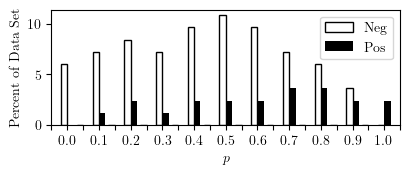

In [17]:
def Plot_Prediction_Wide(y_test, y_proba, filename, title):
    print ('Plot_Prediction()')
    print (filename)
    
#    print ('y_test = ', y_test)
#    print ('y_proba = ',y_proba)

#    y_test = y_test.numpy()
    A = pd.DataFrame(y_proba, columns=['HOSPITAL'])
    B = pd.DataFrame(y_test, columns=['HOSPITAL'])
    B = B.reset_index(drop=True)
    C = A[B['HOSPITAL']==0]
    D = A[B['HOSPITAL']==1]
#    print ("A = pd.DataFrame(y_proba, columns=['HOSPITAL'])")
#    display(A)
#    print ("B = pd.DataFrame(y_test, columns=['HOSPITAL'])")
#    display(B)
#    print ("C = A[B['HOSPITAL']==0]")
#    display(C)
#    print ("D = A[B['HOSPITAL']==1]")
#    display(D)
    n = 20
#    bins= [x/n - 1/(2*n) for x in range (-1, n+3)]
    bins= [x/n for x in range (-1, n+1)]
#    print ('Bins = ', bins)
    E = pd.cut(C['HOSPITAL'], bins=bins, include_lowest=True)
    F = pd.cut(D['HOSPITAL'], bins=bins, include_lowest=True)
#    print ("E = pd.cut(C['HOSPITAL'], bins=bins, include_lowest=True)")
#    display(E)
#    print ("F = pd.cut(D['HOSPITAL'], bins=bins, include_lowest=True)")
#    display(F)
    
    G = E.value_counts(sort=False)
    H = F.value_counts(sort=False)
#    print ("G = E.value_counts(sort=False)")
#    display(G)
#    print ("H = F.value_counts(sort=False)")
#    display(H)

    G = G/len(y_proba)*100
    H = H/len(y_proba)*100
#    print ("G = G/len(y_proba)*100")
#    display(G)
#    print ("H = H/len(y_proba)*100")
#    display(H)

    fig = plt.figure(figsize=(4.5,1.5)) # Create matplotlib figure
    ax = fig.add_subplot(111) # Create matplotlib axes
    
    G.plot(kind='bar', fill=False, ax=ax, width=0.4, position=1)
    H.plot(kind='bar', color='black', ax=ax, width=0.4, position=0)
    ticks = [n/20*i for i in range (-1,22)]
#    print ('ticks = ', ticks)
    plt.xticks(
        ticks = ticks,
        labels = ['','0.0', '', '0.1', '', '0.2', '', '0.3', '', '0.4', '', '0.5', '', '0.6', '', '0.7', '', '0.8', '', '0.9', '', '1.0', ''],
        rotation=0
    )
    ax.legend(['Neg', 'Pos'])
#    plt.title(title)
    plt.xlabel('$p$')
    plt.ylabel('Percent of Data Set')
    plt.savefig('./Images/' + filename + '_Pred_Wide.png', bbox_inches="tight", pad_inches=0.05)
    plt.savefig('./Images/' + filename + '_Pred_Wide.pgf', bbox_inches="tight", pad_inches=0.05)
    print ('./Images/' + filename + '_Pred_Wide.png')
    plt.show()
    plt.close()
    print ()

def Test_Plot_Prediction_Wide():
    
    y_proba = (
        [0.0]*5 + 
        [0.0]*0 + 
        [0.1]*6 + 
        [0.1]*1 + 
        [0.2]*7 + 
        [0.2]*2 + 
        [0.3]*6 + 
        [0.3]*1 + 
        [0.4]*8 + 
        [0.4]*2 + 
        [0.5]*9 + 
        [0.5]*2 + 
        [0.6]*8 + 
        [0.6]*2 + 
        [0.7]*6 + 
        [0.7]*3 + 
        [0.8]*5 + 
        [0.8]*3 + 
        [0.9]*3 + 
        [0.9]*2 + 
        [1.0]*0 + 
        [1.0]*2 
    )
    y_test = (
        [0]*5 + 
        [1]*0 + 
        [0]*6 + 
        [1]*1 + 
        [0]*7 + 
        [1]*2 + 
        [0]*6 + 
        [1]*1 + 
        [0]*8 + 
        [1]*2 + 
        [0]*9 + 
        [1]*2 + 
        [0]*8 + 
        [1]*2 + 
        [0]*6 + 
        [1]*3 + 
        [0]*5 + 
        [1]*3 + 
        [0]*3 + 
        [1]*2 + 
        [0]*0 + 
        [1]*2 
    )
    Plot_Prediction_Wide(y_test, y_proba, 'Test', 'Test')
    
Test_Plot_Prediction_Wide()

## Switching between FP/TP and Precision

$$\text{Precision} = \frac{TP}{FP+TP}$$

$$\frac{1}{\text{Precision}} = \frac{FP+TP}{TP} = \frac{FP}{TP} + \frac{TP}{TP} = \frac{FP}{TP} +  1$$

$$\frac{FP}{TP} + 1 = \frac{1}{\text{Precision}}$$

$$\frac{FP}{TP} = \frac{1}{\text{Precision}} - 1 = \frac{1}{\text{Precision}} - \frac{\text{Precision}}{\text{Precision}}  = \frac{1 - \text{Precision}}{\text{Precision}}$$

- In a previous version I had wanted $FP/TP$ to equal either 2.0, 1.0, or 0.5, indicating that we were willing to send 2 unnecessary ambulances for each necessary one, etc.  
    - $FP/TP = 2.0$ corresponds to precision = 1/3
    - $FP/TP = 1.0$ corresponds to precision = 1/2
    - $FP/TP = 0.5$ corresponds to precision = 2/3

- Neg/Pos corresponds to marginal precision similarly

In [18]:
def Value_Counts_y_proba(y_proba, filename):
#    print ()
    print ('Value_Counts_y_proba')
#    print (type(y_proba))
    Y_proba = pd.Series(y_proba)
    A = Y_proba.value_counts().reset_index(drop=True)
    n = len(y_proba)
    nA = len(A)
#    display(Y_proba)
#    display(A)
    B = A.cumsum()
#    display(B)
#    print (B[10])
#    print ()
    cutoff_95 = B.sub(0.95*n).abs().idxmin() + 1
    cutoff_90 = B.sub(0.90*n).abs().idxmin() + 1
    cutoff_80 = B.sub(0.80*n).abs().idxmin() + 1
    m = Y_proba.min()
    M = Y_proba.max()
    print (n, nA)
    print (cutoff_95)
#    print ()

    n100 = min(100, len(B)-1)
    n200 = min(200, len(B)-1)
#    print ('n200 = ', n200)
    f = open('./Analyze_Proba/Value_Counts_y_proba.csv', 'a')
    f.write('%s,%d,%d,%0.4f,%d,%0.4f,%d,%0.4f,%d,%0.4f,%d,%0.4f,%d,%0.4f,%d,%0.4f,%d,%0.4f,%0.4f,%0.4f\n' % (
        filename, n, nA, nA/n, 
        cutoff_95, cutoff_95/n,
        cutoff_90, cutoff_90/n,
        cutoff_80, cutoff_80/n,
        B[10], B[10]/n,
        B[20], B[20]/n,
        B[n100], B[n100]/n,
        B[n200], B[n200]/n,
        m,M,
    ))
    f.close()
    
    H = Y_proba.value_counts().head(100)
    Filename = './Analyze_Proba/' + filename + '_Value_Counts.csv'
    H.to_csv(Filename)
    
    
    print ('Finished')
    return 0
    
def Create_Files_for_Value_Counts_y_proba():
    f = open('./Analyze_Proba/Value_Counts_y_proba.csv', 'w')
    f.write("Filename,n,nUnique,nUnique/n,95%,95%/n,90%,90%/n,80%,80%/n,B[10],B[10]/n,B[20],B[20]/n,B[100],B[100]/n,B[200],B[200],min,max,\n")
    f.close()
    
#Create_Files_for_Value_Counts_y_proba()

def Create_Files_for_Lengths_of_fpr_tpr():
    f = open('./Analyze_Proba/Lengths_of_fpr_tpr.csv', 'w')
    f.write("Filename,len(y_proba),nUnique(y_proba),len(fpr),nUnique(fpr),len(tpr),nUnique(tpr),len(fpr tpr),nUnique(fpr tpr)\n")
    f.close()
    
def Create_Files_for_ROC_AUC():
    f = open('./Analyze_Proba/ROC_AUC.csv', 'w')
    f.write("Filename,ROC_AUC\n")
    f.close()
    
    
    
def Test_Value_Counts_y_proba():
    A = [5]*50 + [6]*20 + [i for i in range (10,40)]*2 + [i for i in range (100,400)]
    Value_Counts_y_proba(A, 'Test')

Test_Value_Counts_y_proba()

    


Value_Counts_y_proba
430 332
310
Finished


In [19]:
def Analyze_Prediction(y_test, y_proba, filename, title):
    print ('Analyze_Prediction()')
    print (filename)
    
#    Value_Counts_y_proba(y_proba, filename)
    
#    print (y_test)
#    print (y_proba)
#    return 0
#    y_test = y_test.numpy()
    A = pd.DataFrame(y_proba, columns=['HOSPITAL'])
    B = pd.DataFrame(y_test, columns=['HOSPITAL'])
    B = B.reset_index(drop=True)
    C = A[B['HOSPITAL']==0]
    D = A[B['HOSPITAL']==1]
#    print ('print (len(A), len(C), len(D), len(C) + len(D))')
#    print (len(A), len(C), len(D), len(C) + len(D))

    N = len(C)
    P = len(D)
    
    ##### 10 bins
    n = 10
    bins= [x/n for x in range (-1, n+1)]
#    print (bins)
    E = pd.cut(C['HOSPITAL'], bins=bins, include_lowest=True)
    F = pd.cut(D['HOSPITAL'], bins=bins, include_lowest=True)
    
    G = E.value_counts(sort=False)
    H = F.value_counts(sort=False)

    Analyze = pd.DataFrame()
    Analyze['Neg'] = G
    Analyze['Pos'] = H
    Analyze['p'] = bins[1:]
#    Analyze['Neg/Pos'] = Analyze['Neg']/Analyze['Pos']
    Analyze['$\\frac{\\text{Pos}}{\\text{Neg}+\\text{Pos}}$'] = Analyze['Pos']/(Analyze['Pos'] + Analyze['Neg'])
    Analyze['TN'] = Analyze['Neg'].cumsum()
    Analyze['FP'] = N - Analyze['TN']
    Analyze['FN'] = Analyze['Pos'].cumsum()
    Analyze['TP'] = P - Analyze['FN']
#    Analyze['FP/TP'] = Analyze['FP']/Analyze['TP']
#    Analyze['FP+TP'] = Analyze['FP'] + Analyze['TP']
    Analyze['Prec'] = Analyze['TP']/(Analyze['FP'] + Analyze['TP'])
    Analyze['Rec'] =  Analyze['TP']/(Analyze['FN'] + Analyze['TP'])
    Analyze['$\\frac{\\text{FP}}{\\text{P}}$'] =  Analyze['FP']/(Analyze['FN'] + Analyze['TP'])
    
    Analyze['Neg']=Analyze['Neg'].apply('{:,}'.format)
    Analyze['Pos']=Analyze['Pos'].apply('{:,}'.format)
    Analyze['TN']=Analyze['TN'].apply('{:,}'.format)
    Analyze['FP']=Analyze['FP'].apply('{:,}'.format)
    Analyze['FN']=Analyze['FN'].apply('{:,}'.format)
    Analyze['TP']=Analyze['TP'].apply('{:,}'.format)
#    Analyze['FP+TP']=Analyze['FP+TP'].apply('{:,}'.format)
    
#    Analyze['Neg/Pos']=Analyze['Neg/Pos'].apply('{:.2f}'.format)
    Analyze['$\\frac{\\text{Pos}}{\\text{Neg}+\\text{Pos}}$']=Analyze['$\\frac{\\text{Pos}}{\\text{Neg}+\\text{Pos}}$'].apply('{:.2f}'.format)
#    Analyze['FP/TP']=Analyze['FP/TP'].apply('{:.2f}'.format)
    Analyze['Prec']=Analyze['Prec'].apply('{:.2f}'.format)
    Analyze['Rec']=Analyze['Rec'].apply('{:.2f}'.format)
    Analyze['$\\frac{\\text{FP}}{\\text{P}}$']=Analyze['$\\frac{\\text{FP}}{\\text{P}}$'].apply('{:.2f}'.format)
        
#    Analyze.index.name = 'p'
    Analyze.set_index('p', inplace=True)
#    print ('./Analyze_Proba/' + filename + '_10.tex')
#    print (len(y_proba))
#    display(Analyze)
    Analyze.to_csv('./Analyze_Proba/' + filename + '_10.csv', index=True)
    Analyze.to_latex(
        './Analyze_Proba/' + filename + '_10.tex', 
        index=True, 
        float_format="{:.2f}".format, 
        column_format='rrrcrrrrrrrrrrr',
        escape=False
    )



    ##### 20 bins
    n = 20
    bins= [x/n for x in range (-1, n+1)]
#    print (bins)
    E = pd.cut(C['HOSPITAL'], bins=bins, include_lowest=True)
    F = pd.cut(D['HOSPITAL'], bins=bins, include_lowest=True)
    
    G = E.value_counts(sort=False)
    H = F.value_counts(sort=False)

    Analyze = pd.DataFrame()
    Analyze['Neg'] = G
    Analyze['Pos'] = H
    Analyze['p'] = bins[1:]
#    Analyze['Neg/Pos'] = Analyze['Neg']/Analyze['Pos']
    Analyze['$\\frac{\\text{Pos}}{\\text{Neg}+\\text{Pos}}$'] = Analyze['Pos']/(Analyze['Pos'] + Analyze['Neg'])
    Analyze['TN'] = Analyze['Neg'].cumsum()
    Analyze['FP'] = N - Analyze['TN']
    Analyze['FN'] = Analyze['Pos'].cumsum()
    Analyze['TP'] = P - Analyze['FN']
#    Analyze['FP/TP'] = Analyze['FP']/Analyze['TP']
#    Analyze['FP+TP'] = Analyze['FP'] + Analyze['TP']
    Analyze['Prec'] = Analyze['TP']/(Analyze['FP'] + Analyze['TP'])
    Analyze['Rec'] =  Analyze['TP']/(Analyze['FN'] + Analyze['TP'])
    Analyze['$\\frac{\\text{FP}}{\\text{P}}$'] =  Analyze['FP']/(Analyze['FN'] + Analyze['TP'])
    
    Analyze['Neg']=Analyze['Neg'].apply('{:,}'.format)
    Analyze['Pos']=Analyze['Pos'].apply('{:,}'.format)
    Analyze['TN']=Analyze['TN'].apply('{:,}'.format)
    Analyze['FP']=Analyze['FP'].apply('{:,}'.format)
    Analyze['FN']=Analyze['FN'].apply('{:,}'.format)
    Analyze['TP']=Analyze['TP'].apply('{:,}'.format)
#    Analyze['FP+TP']=Analyze['FP+TP'].apply('{:,}'.format)
    
#    Analyze['Neg/Pos']=Analyze['Neg/Pos'].apply('{:.2f}'.format)
    Analyze['$\\frac{\\text{Pos}}{\\text{Neg}+\\text{Pos}}$']=Analyze['$\\frac{\\text{Pos}}{\\text{Neg}+\\text{Pos}}$'].apply('{:.2f}'.format)
#    Analyze['FP/TP']=Analyze['FP/TP'].apply('{:.2f}'.format)
    Analyze['Prec']=Analyze['Prec'].apply('{:.2f}'.format)
    Analyze['Rec']=Analyze['Rec'].apply('{:.2f}'.format)
    Analyze['$\\frac{\\text{FP}}{\\text{P}}$']=Analyze['$\\frac{\\text{FP}}{\\text{P}}$'].apply('{:.2f}'.format)
        
#    Analyze.index.name = 'p'
    Analyze.set_index('p', inplace=True)
#    print ('./Analyze_Proba/' + filename + '_10.tex')
#    print (len(y_proba))
#    display(Analyze)
    Analyze.to_csv('./Analyze_Proba/' + filename + '_20.csv', index=True)
    Analyze.to_latex(
        './Analyze_Proba/' + filename + '_20.tex', 
        index=True, 
        float_format="{:.2f}".format, 
        column_format='rrrcrrrrrrrrrrr',
        escape=False
    )




    ##### 100 bins
    n = 100
    bins= [x/n for x in range (-1, n+1)]
#    print (bins)
    E = pd.cut(C['HOSPITAL'], bins=bins, include_lowest=True)
    F = pd.cut(D['HOSPITAL'], bins=bins, include_lowest=True)
    
    G = E.value_counts(sort=False)
    H = F.value_counts(sort=False)

    Analyze = pd.DataFrame()
    Analyze['Neg'] = G
    Analyze['Pos'] = H
    Analyze['p'] = bins[1:]
#    Analyze['Neg/Pos'] = Analyze['Neg']/Analyze['Pos']
    Analyze['$\\frac{\\text{Pos}}{\\text{Neg}+\\text{Pos}}$'] = Analyze['Pos']/(Analyze['Pos'] + Analyze['Neg'])
    Analyze['TN'] = Analyze['Neg'].cumsum()
    Analyze['FP'] = N - Analyze['TN']
    Analyze['FN'] = Analyze['Pos'].cumsum()
    Analyze['TP'] = P - Analyze['FN']
#    Analyze['FP/TP'] = Analyze['FP']/Analyze['TP']
#    Analyze['FP+TP'] = Analyze['FP'] + Analyze['TP']
    Analyze['Prec'] = Analyze['TP']/(Analyze['FP'] + Analyze['TP'])
    Analyze['Rec'] =  Analyze['TP']/(Analyze['FN'] + Analyze['TP'])
    Analyze['$\\frac{\\text{FP}}{\\text{P}}$'] =  Analyze['FP']/(Analyze['FN'] + Analyze['TP'])
    
    A = Analyze.copy(deep=True)
    
    Analyze['Neg']=Analyze['Neg'].apply('{:,}'.format)
    Analyze['Pos']=Analyze['Pos'].apply('{:,}'.format)
    Analyze['TN']=Analyze['TN'].apply('{:,}'.format)
    Analyze['FP']=Analyze['FP'].apply('{:,}'.format)
    Analyze['FN']=Analyze['FN'].apply('{:,}'.format)
    Analyze['TP']=Analyze['TP'].apply('{:,}'.format)
#    Analyze['FP+TP']=Analyze['FP+TP'].apply('{:,}'.format)
    
#    Analyze['Neg/Pos']=Analyze['Neg/Pos'].apply('{:.2f}'.format)
    Analyze['$\\frac{\\text{Pos}}{\\text{Neg}+\\text{Pos}}$']=Analyze['$\\frac{\\text{Pos}}{\\text{Neg}+\\text{Pos}}$'].apply('{:.2f}'.format)
#    Analyze['FP/TP']=Analyze['FP/TP'].apply('{:.2f}'.format)
    Analyze['Prec']=Analyze['Prec'].apply('{:.2f}'.format)
    Analyze['Rec']=Analyze['Rec'].apply('{:.2f}'.format)
    Analyze['$\\frac{\\text{FP}}{\\text{P}}$']=Analyze['$\\frac{\\text{FP}}{\\text{P}}$'].apply('{:.2f}'.format)
        
#    Analyze.index.name = 'p'
    Analyze.set_index('p', inplace=True)
#    print ('./Analyze_Proba/' + filename + '_10.tex')
#    print (len(y_proba))
#    display(Analyze)
    Analyze.to_csv('./Analyze_Proba/' + filename + '_100.csv', index=True)
    Analyze.to_latex(
        './Analyze_Proba/' + filename + '_100.tex', 
        index=True, 
        float_format="{:.2f}".format, 
        column_format='rrrcrrrrrrrrrrr',
        escape=False
    )


    
    # Append CSV files with results from multiple models
    A.set_index('p', inplace=True)
    A.insert(0, 'Filename', filename)
    
    # Remove rows with negligible number of samples
    A = A[A['Neg'] >= 20]
    A = A[A['Pos'] >= 20]
    
    
    A_closest = A.iloc[(A['$\\frac{\\text{Pos}}{\\text{Neg}+\\text{Pos}}$'] - 0.333).abs().argsort()[:1]].head(1)
    A_closest.to_csv('./Analyze_Proba/mProb_0_333.csv', mode='a', 
        index=True, header=False, float_format="{:.2f}".format)
    A_closest['Filename'] = A_closest['Filename'].str.replace('_','\\_')
    A_closest.to_csv('./Analyze_Proba/mProb_0_333.tex', 
                     mode='a', sep='&', lineterminator='\\cr\n',
                    index=True, header=False, float_format="{:.2f}".format)
    
    A_closest = A.iloc[(A['$\\frac{\\text{Pos}}{\\text{Neg}+\\text{Pos}}$'] - 0.5).abs().argsort()[:1]].head(1)
    A_closest.to_csv('./Analyze_Proba/mProb_0_5.csv', mode='a', index=True, header=False)
    
    A_closest['Filename'] = A_closest['Filename'].str.replace('_','\\_')
    A_closest.to_csv('./Analyze_Proba/mProb_0_5.tex', 
                     mode='a', sep='&', lineterminator='\\cr\n',
                    index=True, header=False, float_format="{:.2f}".format)
    
    A_closest = A.iloc[(A['$\\frac{\\text{Pos}}{\\text{Neg}+\\text{Pos}}$'] - 0.667).abs().argsort()[:1]].head(1)
    A_closest.to_csv('./Analyze_Proba/mProb_0_667.csv', mode='a', index=True, header=False)
    
    A_closest['Filename'] = A_closest['Filename'].str.replace('_','\\_')
    A_closest.to_csv('./Analyze_Proba/mProb_0_667.tex', 
                     mode='a', sep='&', lineterminator='\\cr\n',
                    index=True, header=False, float_format="{:.2f}".format)
    
    A_closest = A.iloc[(A['Prec'] - 0.333).abs().argsort()[:1]].head(1)
    A_closest.to_csv('./Analyze_Proba/Prec_0_333.csv', mode='a', index=True, header=False)
    
    A_closest['Filename'] = A_closest['Filename'].str.replace('_','\\_')
    A_closest.to_csv('./Analyze_Proba/Prec_0_333.tex', 
                     mode='a', sep='&', lineterminator='\\cr\n',
                    index=True, header=False, float_format="{:.2f}".format)
    
    A_closest = A.iloc[(A['Prec'] - 0.5).abs().argsort()[:1]].head(1)
    A_closest.to_csv('./Analyze_Proba/Prec_0_5.csv', mode='a', index=True, header=False)
    
    A_closest['Filename'] = A_closest['Filename'].str.replace('_','\\_')
    A_closest.to_csv('./Analyze_Proba/Prec_0_5.tex', 
                     mode='a', sep='&', lineterminator='\\cr\n',
                    index=True, header=False, float_format="{:.2f}".format)
    
    A_closest = A.iloc[(A['Prec'] - 0.667).abs().argsort()[:1]].head(1)
    A_closest.to_csv('./Analyze_Proba/Prec_0_667.csv', mode='a', index=True, header=False)
    
    A_closest['Filename'] = A_closest['Filename'].str.replace('_','\\_')
    A_closest.to_csv('./Analyze_Proba/Prec_0_667.tex', 
                     mode='a', sep='&', lineterminator='\\cr\n',
                    index=True, header=False, float_format="{:.2f}".format)
    
    A_closest = A.iloc[(A['$\\frac{\\text{FP}}{\\text{P}}$'] - 0.05).abs().argsort()[:1]].head(1)
    A_closest.to_csv('./Analyze_Proba/FP_P_0_05.csv', mode='a', index=True, header=False)
    
    A_closest['Filename'] = A_closest['Filename'].str.replace('_','\\_')
    A_closest.to_csv('./Analyze_Proba/FP_P_0_05.tex', 
                     mode='a', sep='&', lineterminator='\\cr\n',
                    index=True, header=False, float_format="{:.2f}".format)
    
    
def Create_Files_for_Analyze_Prediction():
    f = open('./Analyze_Proba/mPrec_0_5.csv', 'w')
    f.write("p,Filename,Neg,Pos,$\\frac{\\text{Pos}}{\\text{Neg}+\\text{Pos}}$,TN,FP,FN,TP,Prec,Rec,FP/P\n")
    f.close()
    g = open('./Analyze_Proba/mPrec_0_5.tex', 'w')
    g.write("p & Filename & Neg & Pos & $\\frac{\\text{Pos}}{\\text{Neg}+\\text{Pos}}$ & TN & FP & FN & TP & Prec & Rec & FP/P\\cr\\hline\n")
    g.close()
    
    f = open('./Analyze_Proba/mPrec_0_667.csv', 'w')
    f.write("p,Filename,Neg,Pos,$\\frac{\\text{Pos}}{\\text{Neg}+\\text{Pos}}$,TN,FP,FN,TP,Prec,Rec,FP/P\n")
    f.close()
    g = open('./Analyze_Proba/mPrec_0_667.tex', 'w')
    g.write("p & Filename & Neg & Pos & $\\frac{\\text{Pos}}{\\text{Neg}+\\text{Pos}}$ & TN & FP & FN & TP & Prec & Rec & FP/P\\cr\\hline\n")
    g.close()
    
    f = open('./Analyze_Proba/mPrec_0_333.csv', 'w')
    f.write("p,Filename,Neg,Pos,$\\frac{\\text{Pos}}{\\text{Neg}+\\text{Pos}}$,TN,FP,FN,TP,Prec,Rec,FP/P\n")
    f.close()
    g = open('./Analyze_Proba/mPrec_0_333.tex', 'w')
    g.write("p & Filename & Neg & Pos & $\\frac{\\text{Pos}}{\\text{Neg}+\\text{Pos}}$ & TN & FP & FN & TP & Prec & Rec & FP/P\\cr\\hline\n")
    g.close()
    
    f = open('./Analyze_Proba/Prec_0_5.csv', 'w')
    f.write("p,Filename,Neg,Pos,$\\frac{\\text{Pos}}{\\text{Neg}+\\text{Pos}}$,TN,FP,FN,TP,Prec,Rec,FP/P\n")
    f.close()
    g = open('./Analyze_Proba/Prec_0_5.tex', 'w')
    g.write("p & Filename & Neg & Pos & $\\frac{\\text{Pos}}{\\text{Neg}+\\text{Pos}}$ & TN & FP & FN & TP & Prec & Rec & FP/P\\cr\\hline\n")
    g.close()
    
    f = open('./Analyze_Proba/Prec_0_667.csv', 'w')
    f.write("p,Filename,Neg,Pos,$\\frac{\\text{Pos}}{\\text{Neg}+\\text{Pos}}$,TN,FP,FN,TP,Prec,Rec,FP/P\n")
    f.close()
    g = open('./Analyze_Proba/Prec_0_667.tex', 'w')
    g.write("p & Filename & Neg & Pos & $\\frac{\\text{Pos}}{\\text{Neg}+\\text{Pos}}$ & TN & FP & FN & TP & Prec & Rec & FP/P\\cr\\hline\n")
    g.close()
    
    f = open('./Analyze_Proba/Prec_0_333.csv', 'w')
    f.write("p,Filename,Neg,Pos,$\\frac{\\text{Pos}}{\\text{Neg}+\\text{Pos}}$,TN,FP,FN,TP,Prec,Rec,FP/P\n")
    f.close()
    g = open('./Analyze_Proba/Prec_0_333.tex', 'w')
    g.write("p & Filename & Neg & Pos & $\\frac{\\text{Pos}}{\\text{Neg}+\\text{Pos}}$ & TN & FP & FN & TP & Prec & Rec & FP/P\\cr\\hline\n")
    g.close()
    
    f = open('./Analyze_Proba/p_hat_0_05.csv', 'w')
    f.write("p,Filename,Neg,Pos,$\\frac{\\text{Pos}}{\\text{Neg}+\\text{Pos}}$,TN,FP,FN,TP,Prec,Rec,FP/P\n")
    f.close()
    g = open('./Analyze_Proba/p_hat_0_05.tex', 'w')
    g.write("p & Filename & Neg & Pos & $\\frac{\\text{Pos}}{\\text{Neg}+\\text{Pos}}$ & TN & FP & FN & TP & Prec & Rec & FP/P\\cr\\hline\n")
    g.close()
    
    f = open('./Analyze_Proba/p_hat_0_10.csv', 'w')
    f.write("p,Filename,Neg,Pos,$\\frac{\\text{Pos}}{\\text{Neg}+\\text{Pos}}$,TN,FP,FN,TP,Prec,Rec,FP/P\n")
    f.close()
    g = open('./Analyze_Proba/p_hat_0_10.tex', 'w')
    g.write("p & Filename & Neg & Pos & $\\frac{\\text{Pos}}{\\text{Neg}+\\text{Pos}}$ & TN & FP & FN & TP & Prec & Rec & FP/P\\cr\\hline\n")
    g.close()
    
    f = open('./Analyze_Proba/p_hat_0_15.csv', 'w')
    f.write("p,Filename,Neg,Pos,$\\frac{\\text{Pos}}{\\text{Neg}+\\text{Pos}}$,TN,FP,FN,TP,Prec,Rec,FP/P\n")
    f.close()
    g = open('./Analyze_Proba/p_hat_0_15.tex', 'w')
    g.write("p & Filename & Neg & Pos & $\\frac{\\text{Pos}}{\\text{Neg}+\\text{Pos}}$ & TN & FP & FN & TP & Prec & Rec & FP/P\\cr\\hline\n")
    g.close()
    
    f = open('./Analyze_Proba/FP_P_0_05.csv', 'w')
    f.write("p,Filename,Neg,Pos,$\\frac{\\text{Pos}}{\\text{Neg}+\\text{Pos}}$,TN,FP,FN,TP,Prec,Rec,FP/P\n")
    f.close()
    g = open('./Analyze_Proba/FP_P_0_05.tex', 'w')
    g.write("p & Filename & Neg & Pos & $\\frac{\\text{Pos}}{\\text{Neg}+\\text{Pos}}$ & TN & FP & FN & TP & Prec & Rec & FP/P\\cr\\hline\n")
    g.close()



#Create_Files_for_Analyze_Prediction()



In [20]:
def Analyze_Prediction_2(y_test, y_proba, filename, title):
    print ('Analyze_Prediction_2()')
    print (filename)
    
    Value_Counts_y_proba(y_proba, filename)

#    print ('y_proba: ',y_proba)
#    print ('y_test: ', y_test)
    A = pd.DataFrame(y_proba, columns=['y_proba'])
    B = pd.DataFrame(y_test, columns=['y_test'])
    C = pd.concat([A,B], axis=1)
    
    # Sort the y_proba values with p==1 at the top.
    # Make a feature, 'custom_cut'
    # Make a cut large enough that it has at least 1000 elements of each class.
    # Do not cut between two y_proba of the same value; 
    #    keep going until you get to a different y_proba value.
    # Label that cut "0," and the next cut "1," etc.
    
    C.sort_values(by=['y_proba'], ascending=False, inplace=True)
    C = C.reset_index(drop=True)
    C['custom_cut'] = 0
    
    n0 = 0
    n1 = 0
    j = 0
    C['custom_cut'][0] = j
    if C['y_test'][0]==0:
        n0 += 1
    else:
        n1 += 1
    for i in range (1,len(C)):
#        if i%1000==0:
#            print (i, j)
        if (
            min(n0,n1)>=1000 and 
            C['y_proba'][i] != C['y_proba'][i-1] 
        ):
            n0 = 0
            n1 = 0
            j = j+1
        if C['y_test'][i]==0:
            n0 += 1
        else:
            n1 += 1
        C['custom_cut'][i] = j
    print (filename, ' has ', j, ' custom_cut intervals')
#    print (C)
    
    # Count the positive and negative elements in each of the custom_cuts
    
    D = C[C['y_test']==0]
    E = C[C['y_test']==1]

    F = D['custom_cut'].value_counts(sort=False).rename("Neg")
    G = E['custom_cut'].value_counts(sort=False).rename("Pos")
    H = pd.concat([F,G], axis=1, names=['Neg','Pos'])

    H['index1'] = H.index
    H.sort_values(by=['index1'], ascending=False, inplace=True)
    H = H.reset_index()
    H['TN'] = H['Neg'].cumsum()
    H['FP'] = len(D) - H['TN']
    H['FN'] = H['Pos'].cumsum()
    H['TP'] = len(E) - H['FN']
    H['Prec'] = H['TP']/(H['FP'] + H['TP'])
    H['Rec'] = H['TP']/(H['FN'] + H['TP'])
    H['FP/P'] = H['FP']/(H['FN'] + H['TP'])
    

    H['min'] = 0
    H['max'] = 0
    
    for i in range (len(H)):
        I = C[C['custom_cut']==H['index1'][i]]
        H['min'][i] = I['y_proba'].min()
        H['max'][i] = I['y_proba'].max()
    
    H['$\\frac{\\text{Pos}}{\\text{Neg}+\\text{Pos}}$'] = H['Pos']/(H['Neg']+H['Pos'])
    
    H = H.drop('index1', axis='columns')
    H = H.loc[:,['min','max','Neg','Pos','$\\frac{\\text{Pos}}{\\text{Neg}+\\text{Pos}}$','TN','FP','FN','TP','Prec','Rec','FP/P']]

    P = H.copy(deep=True)
    
    H['min']=H['min'].apply('{:.4f}'.format)
    H['max']=H['max'].apply('{:.4f}'.format)
    H['Neg']=H['Neg'].apply('{:,}'.format)
    H['Pos']=H['Pos'].apply('{:,}'.format)
    H['$\\frac{\\text{Pos}}{\\text{Neg}+\\text{Pos}}$']=H['$\\frac{\\text{Pos}}{\\text{Neg}+\\text{Pos}}$'].apply('{:.4f}'.format)
    H['TN']=H['TN'].apply('{:,}'.format)
    H['FP']=H['FP'].apply('{:,}'.format)
    H['FN']=H['FN'].apply('{:,}'.format)
    H['TP']=H['TP'].apply('{:,}'.format)
    H['Prec']=H['Prec'].apply('{:.4f}'.format)
    H['Rec']=H['Rec'].apply('{:.4f}'.format)
    H['FP/P']=H['FP/P'].apply('{:.4f}'.format)
    
    H.to_csv('./Analyze_Proba_2/' + filename + '_Slices.csv', index=True)
    H.to_latex(
        './Analyze_Proba_2/' + filename + '_Slices.tex', 
        index=True, 
#        float_format="{:.4f}".format, 
        column_format='rrrrrrrrrrrrr',
        escape=False
    )

#    print (H)
    
    # Append CSV files with results from multiple models
    P.insert(0, 'Filename', filename)
    
    P_closest = P.iloc[(P['$\\frac{\\text{Pos}}{\\text{Neg}+\\text{Pos}}$'] - 0.333).abs().argsort()[:1]].head(1)
    P_closest.to_csv('./Analyze_Proba_2/mProb_0_333.csv', mode='a', 
        index=True, header=False, float_format="{:.2f}".format)
    P_closest['Filename'] = P_closest['Filename'].str.replace('_','\\_')
    P_closest.to_csv('./Analyze_Proba_2/mProb_0_333.tex', 
                     mode='a', sep='&', lineterminator='\\cr\n',
                    index=True, header=False, 
#                     float_format="{:.4f}".format
                    )
    
    P_closest = P.iloc[(P['$\\frac{\\text{Pos}}{\\text{Neg}+\\text{Pos}}$'] - 0.5).abs().argsort()[:1]].head(1)
    P_closest.to_csv('./Analyze_Proba_2/mProb_0_5.csv', mode='a', index=True, header=False)
    
    P_closest['Filename'] = P_closest['Filename'].str.replace('_','\\_')
    P_closest.to_csv('./Analyze_Proba_2/mProb_0_5.tex', 
                     mode='a', sep='&', lineterminator='\\cr\n',
                    index=True, header=False, float_format="{:.4f}".format)
    
    P_closest = P.iloc[(P['$\\frac{\\text{Pos}}{\\text{Neg}+\\text{Pos}}$'] - 0.667).abs().argsort()[:1]].head(1)
    P_closest.to_csv('./Analyze_Proba_2/mProb_0_667.csv', mode='a', index=True, header=False)
    
    P_closest['Filename'] = P_closest['Filename'].str.replace('_','\\_')
    P_closest.to_csv('./Analyze_Proba_2/mProb_0_667.tex', 
                     mode='a', sep='&', lineterminator='\\cr\n',
                    index=True, header=False, float_format="{:.4f}".format)
    
    P_closest = P.iloc[(P['Prec'] - 0.333).abs().argsort()[:1]].head(1)
    P_closest.to_csv('./Analyze_Proba_2/Prec_0_333.csv', mode='a', index=True, header=False)
    
    P_closest['Filename'] = P_closest['Filename'].str.replace('_','\\_')
    P_closest.to_csv('./Analyze_Proba_2/Prec_0_333.tex', 
                     mode='a', sep='&', lineterminator='\\cr\n',
                    index=True, header=False, float_format="{:.4f}".format)
    
    P_closest = P.iloc[(P['Prec'] - 0.5).abs().argsort()[:1]].head(1)
    P_closest.to_csv('./Analyze_Proba_2/Prec_0_5.csv', mode='a', index=True, header=False)
    
    P_closest['Filename'] = P_closest['Filename'].str.replace('_','\\_')
    P_closest.to_csv('./Analyze_Proba_2/Prec_0_5.tex', 
                     mode='a', sep='&', lineterminator='\\cr\n',
                    index=True, header=False, float_format="{:.4f}".format)
    
    P_closest = P.iloc[(P['Prec'] - 0.667).abs().argsort()[:1]].head(1)
    P_closest.to_csv('./Analyze_Proba_2/Prec_0_667.csv', mode='a', index=True, header=False)
    
    P_closest['Filename'] = P_closest['Filename'].str.replace('_','\\_')
    P_closest.to_csv('./Analyze_Proba_2/Prec_0_667.tex', 
                     mode='a', sep='&', lineterminator='\\cr\n',
                    index=True, header=False, float_format="{:.4f}".format)
    
    P_closest = P.iloc[(P['FP/P'] - 0.05).abs().argsort()[:1]].head(1)
    P_closest.to_csv('./Analyze_Proba_2/FP_P_0_05.csv', mode='a', index=True, header=False)
    
    P_closest['Filename'] = P_closest['Filename'].str.replace('_','\\_')
    P_closest.to_csv('./Analyze_Proba_2/FP_P_0_05.tex', 
                     mode='a', sep='&', lineterminator='\\cr\n',
                    index=True, header=False, float_format="{:.4f}".format)
    
    
    
def Analyze_Prediction_Custom_Cut(y_test, y_proba, filename, title, minCut):
    print ('Analyze_Prediction_Custom_Cut ', minCut)
    filename = filename + '_' + str(minCut)
    print (filename)
    
#    print ('y_proba: ',y_proba)
#    print ('y_test: ', y_test)
    A = pd.DataFrame(y_proba, columns=['y_proba'])
    B = pd.DataFrame(y_test, columns=['y_test'])
    C = pd.concat([A,B], axis=1)
    
    # Sort the y_proba values with p==1 at the top.
    # Make a feature, 'custom_cut'
    # Make a cut large enough that it has at least 1000 elements of each class.
    # Do not cut between two y_proba of the same value; 
    #    keep going until you get to a different y_proba value.
    # Label that cut "0," and the next cut "1," etc.
    
    C.sort_values(by=['y_proba'], ascending=False, inplace=True)
    C = C.reset_index(drop=True)
    C['custom_cut'] = 0
    
    n0 = 0
    n1 = 0
    j = 0
    C['custom_cut'][0] = j
    if C['y_test'][0]==0:
        n0 += 1
    else:
        n1 += 1
    for i in range (1,len(C)):
#        if i%1000==0:
#            print (i, j)
        if (
            min(n0,n1)>=minCut and 
            C['y_proba'][i] != C['y_proba'][i-1] 
        ):
            n0 = 0
            n1 = 0
            j = j+1
        if C['y_test'][i]==0:
            n0 += 1
        else:
            n1 += 1
        C['custom_cut'][i] = j
    print (filename, ' has ', j, ' custom_cut intervals')
#    print (C)
    
    # Count the positive and negative elements in each of the custom_cuts
    
    D = C[C['y_test']==0]
    E = C[C['y_test']==1]

    F = D['custom_cut'].value_counts(sort=False).rename("Neg")
    G = E['custom_cut'].value_counts(sort=False).rename("Pos")
    H = pd.concat([F,G], axis=1, names=['Neg','Pos'])

    H['index1'] = H.index
    H.sort_values(by=['index1'], ascending=False, inplace=True)
    H = H.reset_index()
    H['TN'] = H['Neg'].cumsum()
    H['FP'] = len(D) - H['TN']
    H['FN'] = H['Pos'].cumsum()
    H['TP'] = len(E) - H['FN']
    H['Prec'] = H['TP']/(H['FP'] + H['TP'])
    H['Rec'] = H['TP']/(H['FN'] + H['TP'])
    H['FP/P'] = H['FP']/(H['FN'] + H['TP'])
    

    H['min'] = 0
    H['max'] = 0
    
    for i in range (len(H)):
        I = C[C['custom_cut']==H['index1'][i]]
        H['min'][i] = I['y_proba'].min()
        H['max'][i] = I['y_proba'].max()
    
    H['$\\frac{\\text{Pos}}{\\text{Neg}+\\text{Pos}}$'] = H['Pos']/(H['Neg']+H['Pos'])
    
    H = H.drop('index1', axis='columns')
    H = H.loc[:,['min','max','Neg','Pos','$\\frac{\\text{Pos}}{\\text{Neg}+\\text{Pos}}$','TN','FP','FN','TP','Prec','Rec','FP/P']]

    P = H.copy(deep=True)
    
    H['min']=H['min'].apply('{:.4f}'.format)
    H['max']=H['max'].apply('{:.4f}'.format)
    H['Neg']=H['Neg'].apply('{:,}'.format)
    H['Pos']=H['Pos'].apply('{:,}'.format)
    H['$\\frac{\\text{Pos}}{\\text{Neg}+\\text{Pos}}$']=H['$\\frac{\\text{Pos}}{\\text{Neg}+\\text{Pos}}$'].apply('{:.4f}'.format)
    H['TN']=H['TN'].apply('{:,}'.format)
    H['FP']=H['FP'].apply('{:,}'.format)
    H['FN']=H['FN'].apply('{:,}'.format)
    H['TP']=H['TP'].apply('{:,}'.format)
    H['Prec']=H['Prec'].apply('{:.4f}'.format)
    H['Rec']=H['Rec'].apply('{:.4f}'.format)
    H['FP/P']=H['FP/P'].apply('{:.4f}'.format)
    
    H.to_csv('./Analyze_Proba_2/' + filename + '_Slices.csv', index=True)
    H.to_latex(
        './Analyze_Proba_2/' + filename + '_Slices.tex', 
        index=True, 
#        float_format="{:.4f}".format, 
        column_format='rrrrrrrrrrrrr',
        escape=False
    )


def Create_Files_for_Analyze_Prediction_2():
    f = open('./Analyze_Proba_2/mProb_0_5.csv', 'w')
    f.write("Index,Filename,min,max,Neg,Pos,$\\frac{\\text{Pos}}{\\text{Neg}+\\text{Pos}}$,TN,FP,FN,TP,Prec,Rec,FP/P\n")
    f.close()
    g = open('./Analyze_Proba_2/mProb_0_5.tex', 'w')
    g.write("Index & Filename & min & max & Neg & Pos & $\\frac{\\text{Pos}}{\\text{Neg}+\\text{Pos}}$ & TN & FP & FN & TP & Prec & Rec & FP/P \\cr\\hline\n")
    g.close()

    f = open('./Analyze_Proba_2/mProb_0_667.csv', 'w')
    f.write("Index,Filename,min,max,Neg,Pos,$\\frac{\\text{Pos}}{\\text{Neg}+\\text{Pos}}$,TN,FP,FN,TP,Prec,Rec,FP/P\n")
    f.close()
    g = open('./Analyze_Proba_2/mProb_0_667.tex', 'w')
    g.write("Index & Filename & min & max & Neg & Pos & $\\frac{\\text{Pos}}{\\text{Neg}+\\text{Pos}}$ & TN & FP & FN & TP & Prec & Rec & FP/P \\cr\\hline\n")
    g.close()

    f = open('./Analyze_Proba_2/mProb_0_333.csv', 'w')
    f.write("Index,Filename,min,max,Neg,Pos,$\\frac{\\text{Pos}}{\\text{Neg}+\\text{Pos}}$,TN,FP,FN,TP,Prec,Rec,FP/P\n")
    f.close()
    g = open('./Analyze_Proba_2/mProb_0_333.tex', 'w')
    g.write("Index & Filename & min & max & Neg & Pos & $\\frac{\\text{Pos}}{\\text{Neg}+\\text{Pos}}$ & TN & FP & FN & TP & Prec & Rec & FP/P \\cr\\hline\n")
    g.close()

    f = open('./Analyze_Proba_2/Prec_0_5.csv', 'w')
    f.write("Index,Filename,min,max,Neg,Pos,$\\frac{\\text{Pos}}{\\text{Neg}+\\text{Pos}}$,TN,FP,FN,TP,Prec,Rec,FP/P\n")
    f.close()
    g = open('./Analyze_Proba_2/Prec_0_5.tex', 'w')
    g.write("Index & Filename & min & max & Neg & Pos & $\\frac{\\text{Pos}}{\\text{Neg}+\\text{Pos}}$ & TN & FP & FN & TP & Prec & Rec & FP/P \\cr\\hline\n")
    g.close()

    f = open('./Analyze_Proba_2/Prec_0_667.csv', 'w')
    f.write("Index,Filename,min,max,Neg,Pos,$\\frac{\\text{Pos}}{\\text{Neg}+\\text{Pos}}$,TN,FP,FN,TP,Prec,Rec,FP/P\n")
    f.close()
    g = open('./Analyze_Proba_2/Prec_0_667.tex', 'w')
    g.write("Index & Filename & min & max & Neg & Pos & $\\frac{\\text{Pos}}{\\text{Neg}+\\text{Pos}}$ & TN & FP & FN & TP & Prec & Rec & FP/P \\cr\\hline\n")
    g.close()

    f = open('./Analyze_Proba_2/Prec_0_333.csv', 'w')
    f.write("Index,Filename,min,max,Neg,Pos,$\\frac{\\text{Pos}}{\\text{Neg}+\\text{Pos}}$,TN,FP,FN,TP,Prec,Rec,FP/P\n")
    f.close()
    g = open('./Analyze_Proba_2/Prec_0_333.tex', 'w')
    g.write("Index & Filename & min & max & Neg & Pos & $\\frac{\\text{Pos}}{\\text{Neg}+\\text{Pos}}$ & TN & FP & FN & TP & Prec & Rec & FP/P \\cr\\hline\n")
    g.close()

    f = open('./Analyze_Proba_2/FP_P_0_05.csv', 'w')
    f.write("Index,Filename,min,max,Neg,Pos,$\\frac{\\text{Pos}}{\\text{Neg}+\\text{Pos}}$,TN,FP,FN,TP,Prec,Rec,FP/P\n")
    f.close()
    g = open('./Analyze_Proba_2/FP_P_0_05.tex', 'w')
    g.write("Index & Filename & min & max & Neg & Pos & $\\frac{\\text{Pos}}{\\text{Neg}+\\text{Pos}}$ & TN & FP & FN & TP & Prec & Rec & FP/P \\cr\\hline\n")
    g.close()




In [21]:
def Test_Plot_Prediction_Zoom():
    print ('Idealized_Results()')
    # Set randomness
    np.random.seed(42) # NumPy
    random.seed(42) # Python
    tf.random.set_seed(42) # Tensorflow    

    shape, scale = 3.7, 0.1 # mean=4, std=2*sqrt(2)
    a = np.random.gamma(shape, scale, 150771)
    a = np.where(a>1.0, random.random(), a)
    
    shape, scale = 3.8, 0.1 # mean=4, std=2*sqrt(2)
    b = np.random.gamma(shape, scale, 26621)    
    b = np.where(b>1.0, random.random(), b)
    b = 1-b
    
    y_proba = np.concatenate((a,b),axis=0)
    y_pred = K.round(y_proba)
    y_test = [0]*len(a) + [1]*len(b)  
    
    display(y_proba[:20])
    display(y_pred[:20])
    
    Plot_Prediction(y_test, y_proba, 'Test', 'Test')    
    Plot_Prediction_Wide(y_test, y_proba, 'Test', 'Test')    
    Plot_Prediction_Zoom(y_test, y_proba, 'Test', 'Test', 0.45, 0.55)
    Analyze_Prediction(y_test, y_proba, 'Test', 'Test')    
    
#Test_Plot_Prediction_Zoom()

## Plot ROC Curves

In [22]:
def ROC(y_test, y_proba, p_values, filename):
    print ('ROC()')
    print (filename)
    fpr, tpr, thresholds = roc_curve(y_test, y_proba)
    
    A = np.asarray((fpr,tpr)).T
#    print ()
#    print ('len(fpr/tpr) = ', len(A))
#    print (A[:10])
    A = np.unique(A, axis=0)
#    print (A[:10])
    nU = len(A)
#    print ('Unique fpr/tpr = ', nU)
#    print ()
    
    f = open('./Analyze_Proba/Lengths_of_fpr_tpr.csv', 'a')
    f.write('%s,' % (filename))
    f.write('%d,' % len(y_proba))
    f.write('%d,' % len(np.unique(y_proba)))
    f.write('%d,' % len(fpr))
    f.write('%d,' % len(np.unique(fpr)))
    f.write('%d,' % len(tpr))
    f.write('%d,' % len(np.unique(tpr)))
    f.write('%d,' % len(np.asarray((fpr,tpr)).T))
    f.write('%d,' % len(np.unique(np.asarray((fpr,tpr)).T, axis=0)))
    f.write('\n')
    f.close()

    
    N_median = np.median(y_proba[np.array(y_test)==0])
    P_median = np.median(y_proba[np.array(y_test)==1])
#    print ('N_median, P_median = ', N_median, P_median)

    m = np.quantile(y_proba,0.50)
    p = np.quantile(y_proba,0.25)
    q = np.quantile(y_proba,0.75)
    
    Y = []
#    print ('p_values = ', p_values)
    for X in p_values:
        difference_array = np.absolute(thresholds-X)
        index = difference_array.argmin()
        F = fpr[index]
        T = tpr[index]
        Y.append([X,str(round(X,3)),F,T])
    
    auc_value = auc(fpr, tpr)
    auc_value = round(auc_value,3)
    fig = plt.figure(figsize=(2.0,1.5)) # Create matplotlib figure
    plt.plot([0, 1], [0, 1], 'k--')
    plt.plot(fpr, tpr, color='black', label='AUC={:.3f}'.format(auc_value))
    
    for y in Y:
#        plt.plot([y[2]], [y[3]], marker="o", markersize=20, markeredgecolor="white", markerfacecolor="white")
#        plt.annotate(
#            y[1], # this is the text
#            (y[2], y[3]), # these are the coordinates to position the label
#            ha='center' # horizontal alignment can be left, right or center
#        )
        plt.text(
            y[2], y[3], # these are the coordinates to position the label
            y[1], # this is the text
            backgroundcolor='white', # horizontal alignment can be left, right or center
            bbox=dict(facecolor='white', edgecolor='none', boxstyle='square,pad=0.3')
        )
    plt.xlabel('False positive rate')
    plt.ylabel('True positive rate')
#    plt.title('ROC with AUC {:.3f}'.format(auc_value))
    plt.legend(loc='best')
    plt.savefig('./Images/' + filename + '_ROC.png', bbox_inches="tight", pad_inches=0.05)
    plt.savefig('./Images/' + filename + '_ROC.pgf', bbox_inches="tight", pad_inches=0.05)
    print ('./Images/' + filename + '_ROC.png')
    plt.show()
    plt.close()
    print ()
    return 0

def Test_ROC():
    y_test = [0,0,0,0,0,1]*10000
#    y_proba = [abs(0.45 - y)+round(0.45*random.random(),2) for y in y_test]
    y_proba = [abs(0.45 - y)+round(0.45*random.normalvariate(mu=0.2, sigma=0.2),3) for y in y_test]
#    random.normalvariate(mu=0.0, sigma=1.0)
    y_test = np.array(y_test)
    y_proba = np.array(y_proba)
    print (y_test)
    print (y_proba)
    ROC(y_test, y_proba, [0.5], "tmp")
    
#Test_ROC()



# Five-Fold Cross Validation

In [23]:
def Five_Fold_Cross_Validation(data, model, filename, title):
    print ()
    print ('------------------------')
    print ()
    print (filename)
    print ()
    
    target = 'HOSPITAL'
    skf = StratifiedKFold(n_splits=5, shuffle=True, random_state = random.randint(1,100))
    target_column = data.loc[:,target]
    y_test = []
    y_proba = []
    y_pred = []
    
    iteration = 0
    for train_index, test_index in skf.split(data, target_column):
        print ('K-fold iteration = ', iteration)
        iteration += 1
        
#        print ('len(train_index) = ', len(train_index))
#        print (train_index)
#        print ('len(test_index) = ', len(test_index))
#        print (test_index)
        
        train_fold = data.iloc[train_index]
#        print ()
#        print ('train_fold')
#        display(train_fold)
        
        test_fold = data.iloc[test_index]
#        print ()
#        print ('test_fold')
#        display(test_fold)
#        print ('type(test_fold) = ', type(test_fold))
        
        
        X_train_fold = train_fold.drop(columns=[target])
        X_test_fold = test_fold.drop(columns=[target])
        y_train_fold = train_fold[target].squeeze()        
        y_test_fold = test_fold[target].squeeze()
#        print ('type(y_test_fold) = ', type(y_test_fold))
        
#        print ()
        model.fit(X_train_fold, y_train_fold.values.ravel())
        y_proba_fold = model.predict_proba(X_test_fold)
        y_proba_fold = [x[1] for x in y_proba_fold]
        y_pred_fold = list(np.around(np.array(y_proba_fold),0))
        
        ###
#        print ('X_train_fold')
#        display(X_train_fold)
#        print ('y_train_fold')
#        display(y_train_fold)
#        print ('y_train_fold.value_counts()')
#        display(y_train_fold.value_counts())
#        print ('y_proba_fold')
#        print (y_proba_fold)
#        ###
#        
        y_test = y_test + y_test_fold.to_list()
        y_proba = y_proba + y_proba_fold
#        print ('len(y_proba) = ', len(y_proba))
        y_pred = y_pred + y_pred_fold

    y_test = np.array(y_test)
    y_proba = np.array(y_proba)
    y_pred = np.array(y_pred)
    
    DF = pd.DataFrame(y_test, columns=['y_test'])
    DF['y_proba'] = y_proba
    DF['y_pred'] = y_pred
    DF.to_csv('../../Big_Files/' + filename + '.csv')
#    print (DF)
    
    
#    Chart_and_Plots(y_test, y_proba, y_pred, filename, title)
    
    
    print ()
#    return model    


In [24]:
def BRFC_5_Fold(data, target, alpha, filename):
     
    title = ''
    model = BalancedRandomForestClassifier(
        bootstrap = True, ccp_alpha = 0.0, criterion = 'gini', 
        max_depth = None,
#        max_depth = 40, 
        max_features = 'sqrt', 
        max_leaf_nodes = None,
#        max_leaf_nodes = 10000,  
        max_samples = None, 
        min_impurity_decrease = 0.0, 
        min_samples_leaf = 1, 
        min_samples_split = 2, 
        min_weight_fraction_leaf = 0.0, 
        n_estimators = 100, 
#        n_estimators = 1000, 
        n_jobs = None, 
        oob_score = False, 
        random_state = random.randint(1,100), 
        replacement = False, 
        sampling_strategy = 'auto', 
        verbose = 0, 
        warm_start = False,
        class_weight = {0:1-alpha, 1:alpha}
    )
    Five_Fold_Cross_Validation(data, model, filename, title)



In [25]:
def RFC_5_Fold(data, target, filename):
    title = ''
    model = RandomForestClassifier(max_depth=2, random_state = random.randint(1,100))
    Five_Fold_Cross_Validation(data, model, filename, title)


In [26]:
def AdaBoost_5_Fold(data, target, filename):
    title = ''
    model = AdaBoostClassifier(n_estimators=100, random_state = random.randint(1,100))
    Five_Fold_Cross_Validation(data, model, filename, title)


In [27]:
def RUSBoost_5_Fold(data, target, filename):
    title = ''
    estimator = DecisionTreeClassifier(
        max_depth=1,
#        class_weight={0:(1+r_target)/(2*r_target), 1:(1+r_target)/(2*1)},
    )    
    model = RUSBoostClassifier(
        n_estimators=1000, 
        estimator=estimator,
        algorithm='SAMME.R', 
        random_state = random.randint(1,100)
    )
    Five_Fold_Cross_Validation(data, model, filename, title)


In [28]:
def BalancedBagging_5_Fold(data, target, filename):
    title = ''
    model = BalancedBaggingClassifier(
        random_state = random.randint(1,100)
    )
    Five_Fold_Cross_Validation(data, model, filename, title)
    

In [29]:
def EasyEnsemble_5_Fold(data, target, filename):
    title = ''
    estimator = AdaBoostClassifier(n_estimators=10, random_state = random.randint(1,100))
    model = EasyEnsembleClassifier(n_estimators=10, estimator=estimator, random_state = random.randint(1,100))
    Five_Fold_Cross_Validation(data, model, filename, title)

    

In [30]:
def LogisticRegression_5_Fold(data, target, alpha, filename):
    title = ''
    model = LogisticRegression(
#        class_weight={0:(1+r_target)/(2*r_target), 1:(1+r_target)/(2*1)}
        class_weight = {0:1-alpha, 1:alpha},
        max_iter=1000,
        random_state = random.randint(1,100),
    )
    Five_Fold_Cross_Validation(data, model, filename, title)


In [31]:
def KBFC_5_Fold(data, target, alpha, gamma, filename):
    print ()
    print ('------------------------')
    print ()
    print (filename)
    print ()
    
    target = 'HOSPITAL'
    skf = StratifiedKFold(n_splits=5, shuffle=True, random_state  = random.randint(1,100))
    target_column = data.loc[:,target]
    y_test = []
    y_proba = []
    y_pred = []
    
    iteration = 0
    for train_index, test_index in skf.split(data, target_column):
        print ()
        print ()
        print ('K-fold iteration = ', iteration)
        iteration += 1
        
#        print ('len(train_index) = ', len(train_index))
#        print (train_index)
#        print ('len(test_index) = ', len(test_index))
#        print (test_index)
        
        train_fold = data.iloc[train_index]
#        print ()
#        print ('train_fold')
#        display(train_fold)
        
        test_fold = data.iloc[test_index]
#        print ()
#        print ('test_fold')
#        display(test_fold)
#        print ('type(test_fold) = ', type(test_fold))
        
        
        X_train_fold = train_fold.drop(columns=[target])
        X_test_fold = test_fold.drop(columns=[target])
        y_train_fold = train_fold[target].squeeze()        
        y_test_fold = test_fold[target].squeeze()
#        print ('type(y_test_fold) = ', type(y_test_fold))

#        print ('len(X_train_fold) = ', len(X_train_fold))
#        print ('len(X_test_fold) = ', len(X_test_fold))
#        print ('len(y_train_fold) = ', len(y_train_fold))
#        print ('len(y_test_fold) = ', len(y_test_fold))
#        print ()
        
#        print ()

        loss_function = tf.keras.losses.BinaryFocalCrossentropy(
            apply_class_balancing=True,
            alpha=alpha,
            gamma=gamma,
    #        from_logits=False,
    #        label_smoothing=0.0,
    #        axis=-1,
    #        reduction=losses_utils.ReductionV2.AUTO,
    #        name='binary_focal_crossentropy'
        )   
    
        # create model
        model = Sequential()
#        print ('data.shape = ', data.shape, data.shape[-1])
        model.add(Dense(60, input_shape=(data.shape[-1]-1,), activation='relu'))
#        model.add(Dense(30, activation='relu'))
        model.add(Dense(1, activation='sigmoid'))    
        # Compile model
        metrics = [
            keras.metrics.Precision(name="precision"),
            keras.metrics.Recall(name="recall"),
    #        F1_Metric,
        ]
        model.compile(loss=loss_function, optimizer=tf.keras.optimizers.Adam(), metrics=metrics)
        estimator = KerasClassifier(
            model=model, 
            random_state = random.randint(1,100),
            metrics=metrics,
            batch_size=128, 
            verbose=0,
            epochs=20,
        )
    


        estimator.fit(X_train_fold, y_train_fold.values.ravel())
        y_proba_fold = estimator.predict_proba(X_test_fold)
        y_proba_fold = [x[1] for x in y_proba_fold]
        y_pred_fold = list(np.around(np.array(y_proba_fold),0))
        
        ###
#        print ('X_train_fold')
#        display(X_train_fold.head())
#        print ('y_train_fold')
#        display(y_train_fold.head())
#        print ('y_train_fold.value_counts()')
#        display(y_train_fold.value_counts())
#        print ('X_test_fold')
#        display(X_test_fold.head())
#        print ('y_test_fold')
#        display(y_test_fold.head())
#        print ('y_test_fold.value_counts()')
#        display(y_test_fold.value_counts())
#        print ('y_proba_fold')
#        print (y_proba_fold[:10])
#        ###
#        
        y_test = y_test + y_test_fold.to_list()
        y_proba = y_proba + y_proba_fold
#        print ('len(y_proba) = ', len(y_proba))
        y_pred = y_pred + y_pred_fold

    y_test = np.array(y_test)
    y_proba = np.array(y_proba)
    y_pred = np.array(y_pred)
    
    DF = pd.DataFrame(y_test, columns=['y_test'])
    DF['y_proba'] = y_proba
    DF['y_pred'] = y_pred
    DF.to_csv('../../Big_Files/' + filename + '.csv')
    
#    Chart_and_Plots(y_test, y_proba, y_pred, filename, '')
    
    
    print ()
#    return model    


# Run

In [32]:
def Run_with_Hard_Features(run):
    data = Get_Data()
    data = data.astype('int64')
    target = 'HOSPITAL'
    data = Feature_Engineering_Cross_Two(data)
    data = Thin_to_Hard_Features(data)
    write_filename_features = '_Hard' + run
    data = Get_Dummies(data, target)
    
    y = data[target]
    N = len(y)
    n = len(y[y==1])
    p = (N-n)/n
    alpha_balanced = p/(p+1)
    print ('p = ', p)
    print ('alpha_balanced = ', alpha_balanced)    

    filename = 'RFC' + write_filename_features
    RFC_5_Fold(data, target, filename)
    
    alpha = 0.5
    filename = 'BRFC_alpha_0_5' + write_filename_features
    BRFC_5_Fold(data, target, alpha, filename)
    
    alpha = alpha_balanced
    filename = 'BRFC_alpha_balanced' + write_filename_features
    BRFC_5_Fold(data, target, alpha, filename)
    

    alpha = 0.5
    filename = 'LogReg_alpha_0_5' + write_filename_features
    LogisticRegression_5_Fold(data, target, alpha, filename)

    alpha = alpha_balanced
    filename = 'LogReg_alpha_balanced' + write_filename_features
    LogisticRegression_5_Fold(data, target, alpha, filename)

    AdaBoost_5_Fold(data, target, 'AdaBoost' + write_filename_features)
    BalancedBagging_5_Fold(data, target, 'BalBag' + write_filename_features)
    EasyEnsemble_5_Fold(data, target, 'EEC' + write_filename_features)
    RUSBoost_5_Fold(data, target, 'RUSBoost' + write_filename_features)
    
    alpha = 0.5
    gamma = 0.0
    filename = 'KBFC_alpha_0_5_gamma_0_0' + write_filename_features
    KBFC_5_Fold(data, target, alpha, gamma, filename)

    alpha = alpha_balanced
    gamma = 0.0
    filename = 'KBFC_alpha_balanced_gamma_0_0' + write_filename_features
    KBFC_5_Fold(data, target, alpha, gamma, filename)

    alpha = 0.5
    gamma = 1.0
    filename = 'KBFC_alpha_0_5_gamma_1_0' + write_filename_features
    KBFC_5_Fold(data, target, alpha, gamma, filename)

    alpha = 0.5
    gamma = 2.0
    filename = 'KBFC_alpha_0_5_gamma_2_0' + write_filename_features
    KBFC_5_Fold(data, target, alpha, gamma, filename)
    


In [33]:
def Run_with_Medium_Features(run):
    data = Get_Data()
    data = data.astype('int64')
    target = 'HOSPITAL'
    data = Feature_Engineering_Cross_Two(data)
    data = Thin_to_Medium_Features(data)
    write_filename_features = '_Medium' + run
    data = Get_Dummies(data, target)

    y = data[target]
    N = len(y)
    n = len(y[y==1])
    p = (N-n)/n
    alpha_balanced = p/(p+1)
    print ('p = ', p)
    print ('alpha_balanced = ', alpha_balanced)    

    filename = 'RFC' + write_filename_features
    RFC_5_Fold(data, target, filename)
    
    alpha = 0.5
    filename = 'BRFC_alpha_0_5' + write_filename_features
    BRFC_5_Fold(data, target, alpha, filename)
    
    alpha = alpha_balanced
    filename = 'BRFC_alpha_balanced' + write_filename_features
    BRFC_5_Fold(data, target, alpha, filename)
    

    alpha = 0.5
    filename = 'LogReg_alpha_0_5' + write_filename_features
    LogisticRegression_5_Fold(data, target, alpha, filename)

    alpha = alpha_balanced
    filename = 'LogReg_alpha_balanced' + write_filename_features
    LogisticRegression_5_Fold(data, target, alpha, filename)

    AdaBoost_5_Fold(data, target, 'AdaBoost' + write_filename_features)
    BalancedBagging_5_Fold(data, target, 'BalBag' + write_filename_features)
    EasyEnsemble_5_Fold(data, target, 'EEC' + write_filename_features)
    RUSBoost_5_Fold(data, target, 'RUSBoost' + write_filename_features)
    
    alpha = 0.5
    gamma = 0.0
    filename = 'KBFC_alpha_0_5_gamma_0_0' + write_filename_features
    KBFC_5_Fold(data, target, alpha, gamma, filename)

    alpha = alpha_balanced
    gamma = 0.0
    filename = 'KBFC_alpha_balanced_gamma_0_0' + write_filename_features
    KBFC_5_Fold(data, target, alpha, gamma, filename)

    alpha = 0.5
    gamma = 1.0
    filename = 'KBFC_alpha_0_5_gamma_1_0' + write_filename_features
    KBFC_5_Fold(data, target, alpha, gamma, filename)

    alpha = 0.5
    gamma = 2.0
    filename = 'KBFC_alpha_0_5_gamma_2_0' + write_filename_features
    KBFC_5_Fold(data, target, alpha, gamma, filename)
    


In [34]:
def Run_with_Easy_Features(run):
    data = Get_Data()
    data = data.astype('int64')
    target = 'HOSPITAL'
    data = Feature_Engineering_Cross_Two(data)
    data = Thin_to_Easy_Features(data)
    write_filename_features = '_Easy' + run
    data = Get_Dummies(data, target)

    y = data[target]
    N = len(y)
    n = len(y[y==1])
    p = (N-n)/n
    alpha_balanced = p/(p+1)
    print ('p = ', p)
    print ('alpha_balanced = ', alpha_balanced)    

    filename = 'RFC' + write_filename_features
    RFC_5_Fold(data, target, filename)
    
    alpha = 0.5
    filename = 'BRFC_alpha_0_5' + write_filename_features
    BRFC_5_Fold(data, target, alpha, filename)
    
    alpha = alpha_balanced
    filename = 'BRFC_alpha_balanced' + write_filename_features
    BRFC_5_Fold(data, target, alpha, filename)
    

    alpha = 0.5
    filename = 'LogReg_alpha_0_5' + write_filename_features
    LogisticRegression_5_Fold(data, target, alpha, filename)

    alpha = alpha_balanced
    filename = 'LogReg_alpha_balanced' + write_filename_features
    LogisticRegression_5_Fold(data, target, alpha, filename)

    AdaBoost_5_Fold(data, target, 'AdaBoost' + write_filename_features)
    BalancedBagging_5_Fold(data, target, 'BalBag' + write_filename_features)
    EasyEnsemble_5_Fold(data, target, 'EEC' + write_filename_features)
    RUSBoost_5_Fold(data, target, 'RUSBoost' + write_filename_features)
    
    alpha = 0.5
    gamma = 0.0
    filename = 'KBFC_alpha_0_5_gamma_0_0' + write_filename_features
    KBFC_5_Fold(data, target, alpha, gamma, filename)

    alpha = alpha_balanced
    gamma = 0.0
    filename = 'KBFC_alpha_balanced_gamma_0_0' + write_filename_features
    KBFC_5_Fold(data, target, alpha, gamma, filename)

    alpha = 0.5
    gamma = 1.0
    filename = 'KBFC_alpha_0_5_gamma_1_0' + write_filename_features
    KBFC_5_Fold(data, target, alpha, gamma, filename)

    alpha = 0.5
    gamma = 2.0
    filename = 'KBFC_alpha_0_5_gamma_2_0' + write_filename_features
    KBFC_5_Fold(data, target, alpha, gamma, filename)
    


In [35]:
%%time
Run_with_Hard_Features('_Run_1')
# CPU times: user 4h 45min 20s, sys: 7min 22s, total: 4h 52min 43s
# Wall time: 4h 30min 47s

Get_Data()
data.shape:  (713566, 78)
End Get_Data()

Feature_Engineering_Cross_Two

Thin_to_Hard_Features()
data.shape:  (713566, 40)
End Thin_to_Hard_Features()

Get_Dummies

p =  5.609785468153692
alpha_balanced =  0.84870915934896

------------------------

RFC_Hard_Run_1

K-fold iteration =  0
K-fold iteration =  1
K-fold iteration =  2
K-fold iteration =  3
K-fold iteration =  4


------------------------

BRFC_alpha_0_5_Hard_Run_1

K-fold iteration =  0
K-fold iteration =  1
K-fold iteration =  2
K-fold iteration =  3
K-fold iteration =  4


------------------------

BRFC_alpha_balanced_Hard_Run_1

K-fold iteration =  0
K-fold iteration =  1
K-fold iteration =  2
K-fold iteration =  3
K-fold iteration =  4


------------------------

LogReg_alpha_0_5_Hard_Run_1

K-fold iteration =  0
K-fold iteration =  1
K-fold iteration =  2
K-fold iteration =  3
K-fold iteration =  4


------------------------

LogReg_alpha_balanced_Hard_Run_1

K-fold iteration =  0
K-fold iteration =  1
K-fol

2024-02-18 14:36:45.677374: W tensorflow/tsl/platform/profile_utils/cpu_utils.cc:128] Failed to get CPU frequency: 0 Hz




K-fold iteration =  1


K-fold iteration =  2


K-fold iteration =  3


K-fold iteration =  4


------------------------

KBFC_alpha_balanced_gamma_0_0_Hard_Run_1



K-fold iteration =  0


K-fold iteration =  1


K-fold iteration =  2


K-fold iteration =  3


K-fold iteration =  4


------------------------

KBFC_alpha_0_5_gamma_1_0_Hard_Run_1



K-fold iteration =  0


K-fold iteration =  1


K-fold iteration =  2


K-fold iteration =  3


K-fold iteration =  4


------------------------

KBFC_alpha_0_5_gamma_2_0_Hard_Run_1



K-fold iteration =  0


K-fold iteration =  1


K-fold iteration =  2


K-fold iteration =  3


K-fold iteration =  4

CPU times: user 4h 45min 26s, sys: 6min 39s, total: 4h 52min 5s
Wall time: 4h 30min 48s


In [36]:
%%time
Run_with_Medium_Features('_Run_1')
# CPU times: user 2h 21min 16s, sys: 3min 36s, total: 2h 24min 52s
# Wall time: 2h 19min 48s

Get_Data()
data.shape:  (713566, 78)
End Get_Data()

Feature_Engineering_Cross_Two

Thin_to_Medium_Features()
data.shape:  (713566, 22)
End Thin_to_Medium_Features()

Get_Dummies

p =  5.609785468153692
alpha_balanced =  0.84870915934896

------------------------

RFC_Medium_Run_1

K-fold iteration =  0
K-fold iteration =  1
K-fold iteration =  2
K-fold iteration =  3
K-fold iteration =  4


------------------------

BRFC_alpha_0_5_Medium_Run_1

K-fold iteration =  0
K-fold iteration =  1
K-fold iteration =  2
K-fold iteration =  3
K-fold iteration =  4


------------------------

BRFC_alpha_balanced_Medium_Run_1

K-fold iteration =  0
K-fold iteration =  1
K-fold iteration =  2
K-fold iteration =  3
K-fold iteration =  4


------------------------

LogReg_alpha_0_5_Medium_Run_1

K-fold iteration =  0
K-fold iteration =  1
K-fold iteration =  2
K-fold iteration =  3
K-fold iteration =  4


------------------------

LogReg_alpha_balanced_Medium_Run_1

K-fold iteration =  0
K-fold iterat

In [37]:
%%time
Run_with_Easy_Features('_Run_1')
# CPU times: user 2h 2min 53s, sys: 1min 36s, total: 2h 4min 29s
# Wall time: 2h 3min 30s

Get_Data()
data.shape:  (713566, 78)
End Get_Data()

Feature_Engineering_Cross_Two

Thin_to_Easy_Features()
data.shape:  (713566, 10)
End Thin_to_Easy_Features()

Get_Dummies

p =  5.609785468153692
alpha_balanced =  0.84870915934896

------------------------

RFC_Easy_Run_1

K-fold iteration =  0
K-fold iteration =  1
K-fold iteration =  2
K-fold iteration =  3
K-fold iteration =  4


------------------------

BRFC_alpha_0_5_Easy_Run_1

K-fold iteration =  0
K-fold iteration =  1
K-fold iteration =  2
K-fold iteration =  3
K-fold iteration =  4


------------------------

BRFC_alpha_balanced_Easy_Run_1

K-fold iteration =  0
K-fold iteration =  1
K-fold iteration =  2
K-fold iteration =  3
K-fold iteration =  4


------------------------

LogReg_alpha_0_5_Easy_Run_1

K-fold iteration =  0
K-fold iteration =  1
K-fold iteration =  2
K-fold iteration =  3
K-fold iteration =  4


------------------------

LogReg_alpha_balanced_Easy_Run_1

K-fold iteration =  0
K-fold iteration =  1
K-fol